# Kaggle team name: vijf5!

# Members:
1. Jesse Coenraad -> JesseCoenraad
2. Jordan van Sintanneland -> JordanvanSint
3. Casper Priem -> CasperPriem
4. Jassar Hasiba -> UrClades

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from scipy.signal import find_peaks
from scipy.fft import fft, ifft
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, KFold


from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt


import warnings
warnings.filterwarnings('ignore')


### Data inladen

In [2]:
train = pd.read_csv('train.csv', parse_dates=True)
test = pd.read_csv('test.csv')

# 1. Exploratieve Data Analyse

## 1.1 Toon de datatypes en basisstatistieken van iedere kolom

In [3]:
display(train.head())
display(train.info())
display(train.describe())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


None

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### 1.1.1 Valt hier iets op?

- Geen missende waarde
- De 'temp', 'atemp', 'hum' en 'windspeed' zijn al genormaliseerd
- 'date_hour', is geen DateTime data type

### 1.1.2 Beschrijf de kolommen

- date_hour: Je hebt informatie over de periode van 1-1-2011 t/m 30-11-2012, metingen per uur
- holiday: Vakantiedag of geen vakantiedag
- weathersit: Weersituatie:
    1. Helder, licht bewolkt, deels bewolkt
    2. Mistig , mistig en licht bewolkt
    3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte regen en zwaar bewolkt
    4. Zware regen,  hagel,  zware mist, sneeuw
- temp: genormaliseerde temperatuur
- atemp: genormaliseerde gevoelstemperatuur
- hum: genormaliseerde luchtvochtigheid
- windspeed: genormaliseerde windsnelheid
- cnt: het aantal dat per uur is verhuurd

## 1.2 Voeg tijdserie elementen toe en gebruik passende visualistaites om relevante patronen zichtbaar te maken.

Hier wordt de 'date_hour' kolom omgezet naar een DateTime data type, zodat er Time Series modellen mee kunnen worden gemaakt.

In [4]:
train['date_hour'] = pd.to_datetime(train['date_hour'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   16637 non-null  datetime64[ns]
 1   holiday     16637 non-null  int64         
 2   weathersit  16637 non-null  int64         
 3   temp        16637 non-null  float64       
 4   atemp       16637 non-null  float64       
 5   hum         16637 non-null  float64       
 6   windspeed   16637 non-null  float64       
 7   cnt         16637 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 1.0 MB


Hier worden extra timeseries features toegevoegd om betere voorspellingen te kunnen maken. Aangezien hier ook naar correlaties wordt gekeken staat dit in de EDA, ondanks het toevoegen van de features zelf beter bij 'Feature Engineering' zou passen.

In [5]:
train['hour'] = train['date_hour'].dt.hour
train['day'] = train['date_hour'].dt.dayofweek
train['dayName'] = train['date_hour'].dt.day_name()
train['month'] = train['date_hour'].dt.month
train['week'] = train['date_hour'].dt.isocalendar().week
train['weekend'] = train['day'].apply(lambda x: 1 if x > 4 else 0)
train['season'] = train['month'].apply(lambda x: 1 if x in [12, 1, 2] else 2 if x in [3, 4, 5] else 3 if x in [6, 7, 8] else 4)
train

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,day,dayName,month,week,weekend,season
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,0,5,Saturday,1,52,1,1
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,Saturday,1,52,1,1
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2,5,Saturday,1,52,1,1
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,3,5,Saturday,1,52,1,1
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,4,5,Saturday,1,52,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,19,4,Friday,11,48,0,4
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,20,4,Friday,11,48,0,4
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,21,4,Friday,11,48,0,4
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,22,4,Friday,11,48,0,4


Om uiteindelijk voorspellingen te kunnen doen, wordt hetzelfde gedaan voor de testset

In [6]:
test['date_hour'] = pd.to_datetime(test['date_hour'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   456 non-null    datetime64[ns]
 1   holiday     456 non-null    int64         
 2   weathersit  456 non-null    int64         
 3   temp        456 non-null    float64       
 4   atemp       456 non-null    float64       
 5   hum         456 non-null    float64       
 6   windspeed   456 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 25.1 KB


In [7]:
test['hour'] = test['date_hour'].dt.hour
test['day'] = test['date_hour'].dt.dayofweek
test['dayName'] = test['date_hour'].dt.day_name()
test['month'] = test['date_hour'].dt.month
test['week'] = test['date_hour'].dt.isocalendar().week
test['weekend'] = test['day'].apply(lambda x: 1 if x > 4 else 0)
test['season'] = test['month'].apply(lambda x: 1 if x in [12, 1, 2] else 2 if x in [3, 4, 5] else 3 if x in [6, 7, 8] else 4)
test

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,hour,day,dayName,month,week,weekend,season
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,5,Saturday,12,48,1,1
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,Saturday,12,48,1,1
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,5,Saturday,12,48,1,1
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,5,Saturday,12,48,1,1
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,5,Saturday,12,48,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881,19,2,Wednesday,12,51,0,1
452,2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239,20,2,Wednesday,12,51,0,1
453,2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239,21,2,Wednesday,12,51,0,1
454,2012-12-19 22:00:00,0,1,0.34,0.3485,0.61,0.0896,22,2,Wednesday,12,51,0,1


Plotten van de target kolom 'cnt' ten opzichte van tijdserie elementen

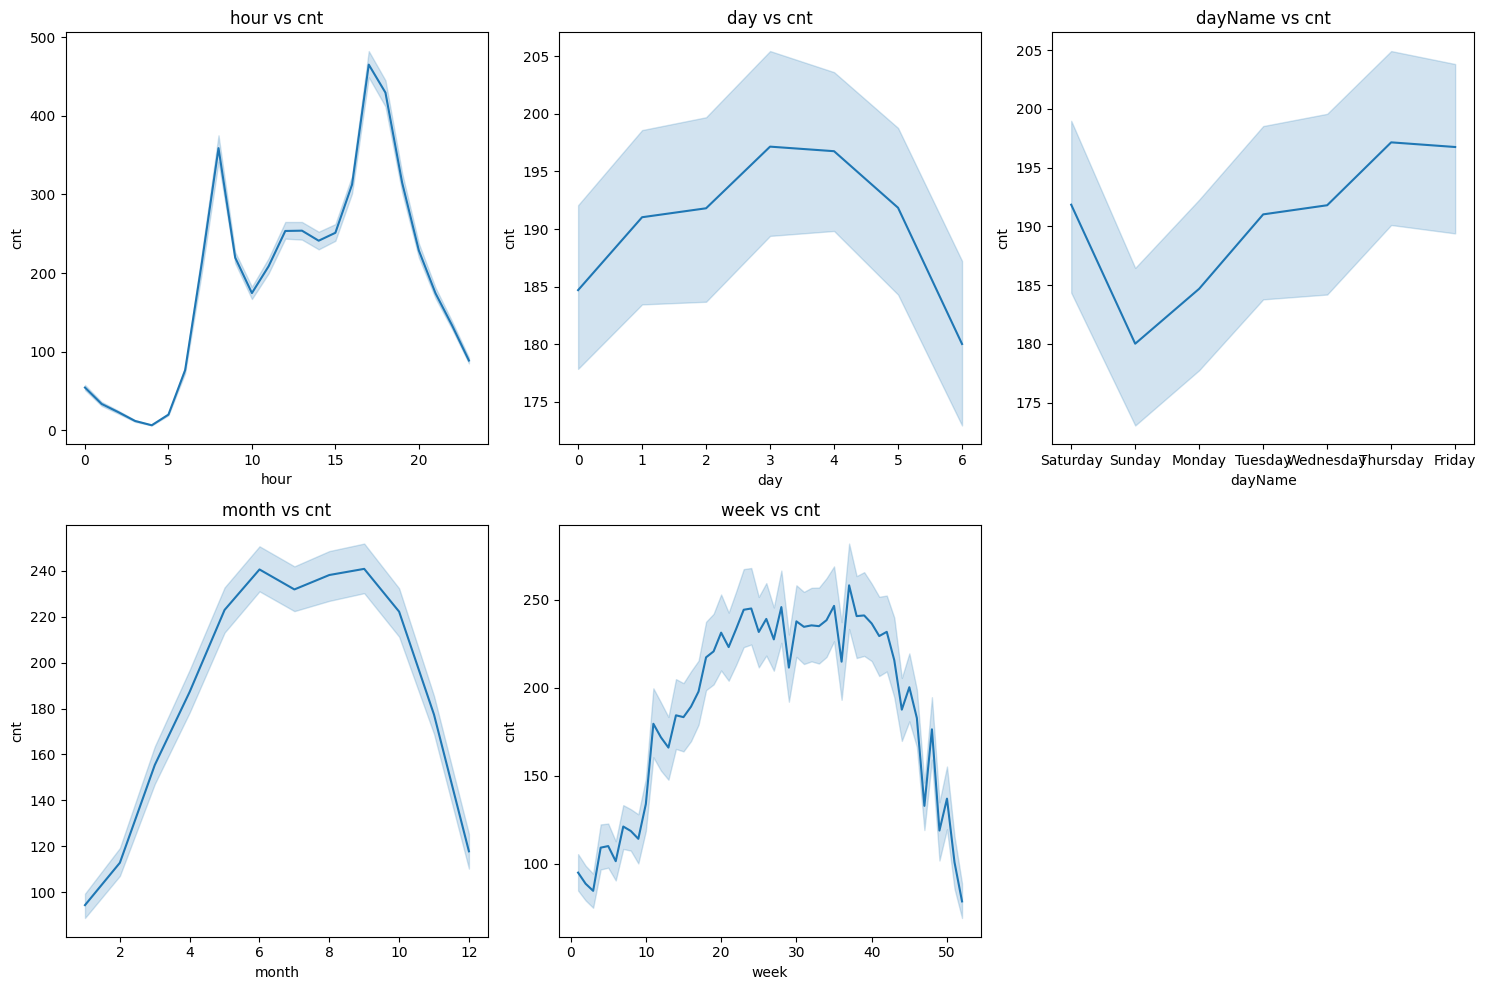

In [8]:

keys = ['hour', 'day', 'dayName', 'month', 'week']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  

for i, key in enumerate(keys):
    row, col = divmod(i, 3)  
    sns.lineplot(data=train, x=key, y='cnt', ax=axes[row, col])
    axes[row, col].set_title(f'{key} vs cnt')

if len(keys) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()  
plt.show()

### 1.2.2 Valt hier iets op?


**Lineplots**
- Hour:

    Er zijn een opvallend patroon in deze grafiek. Zo zijn er grote pieken in het aantal verhuurde producten rond 8 uur 's-ochtends en 6 uur 's-savonds.

- Day/DayName:

    Het valt op dat op de zondag het aantal verhuurde producten aanzienlijk lager is dan de rest van de dagen. 

- Month/Week:

    In het begin en het einde van het jaar is het aantal verhuurde producten een stuk lager dan in het midden van het jaar (winterperiode dus lager, zomerperiode dus hoger).

## 1.3 Relaties

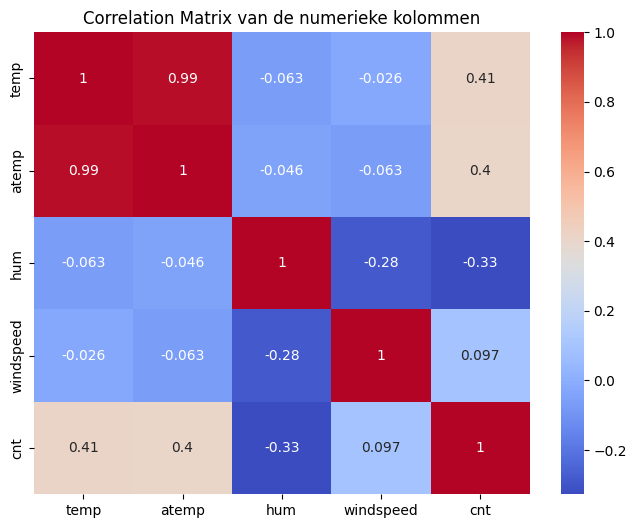

In [10]:
# Correlatiematrix van de numerieke kolommen
plt.figure(figsize=(8, 6))
correlation_matrix = train[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix van de numerieke kolommen')
plt.show()

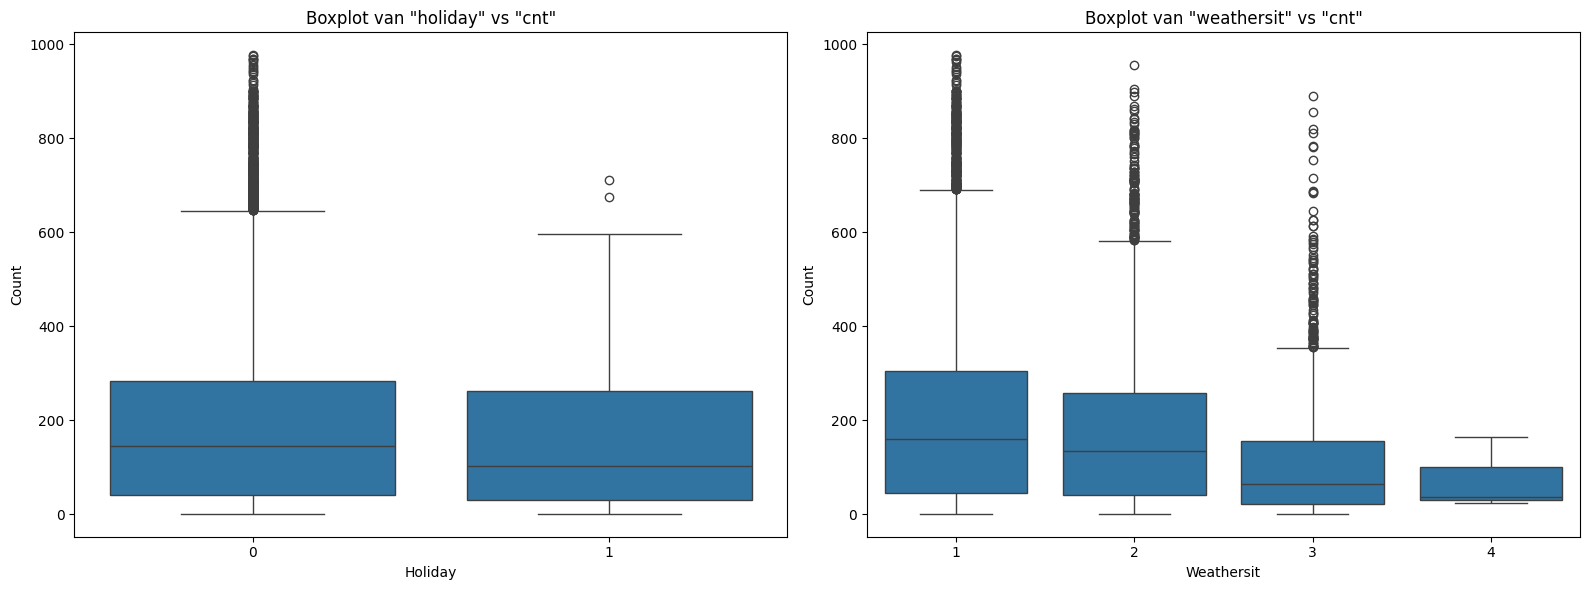

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='holiday', y='cnt', data=train, ax=axes[0])
axes[0].set_title('Boxplot van "holiday" vs "cnt"')
axes[0].set_xlabel('Holiday')
axes[0].set_ylabel('Count')

sns.boxplot(x='weathersit', y='cnt', data=train, ax=axes[1])
axes[1].set_title('Boxplot van "weathersit" vs "cnt"')
axes[1].set_xlabel('Weathersit')
axes[1].set_ylabel('Count')

plt.tight_layout()

plt.show()

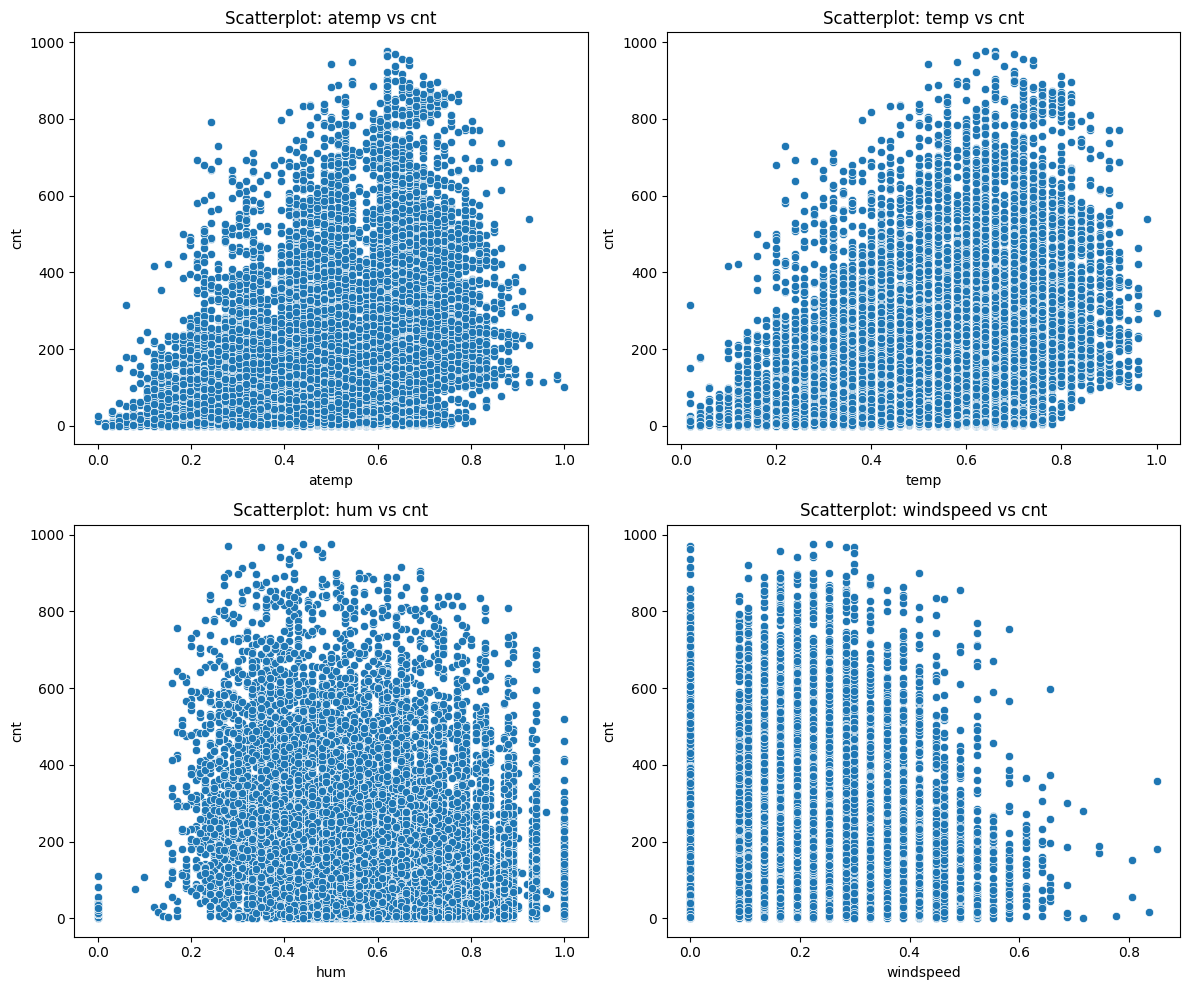

In [12]:
keys = ['atemp', 'temp', 'hum', 'windspeed']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, key in enumerate(keys):
    row, col = divmod(i, 2)  
    sns.scatterplot(data=train, x=key, y='cnt', ax=axes[row, col])
    axes[row, col].set_title(f'Scatterplot: {key} vs cnt')

plt.tight_layout()
plt.show()

#https://www.geeksforgeeks.org/divmod-python-application/

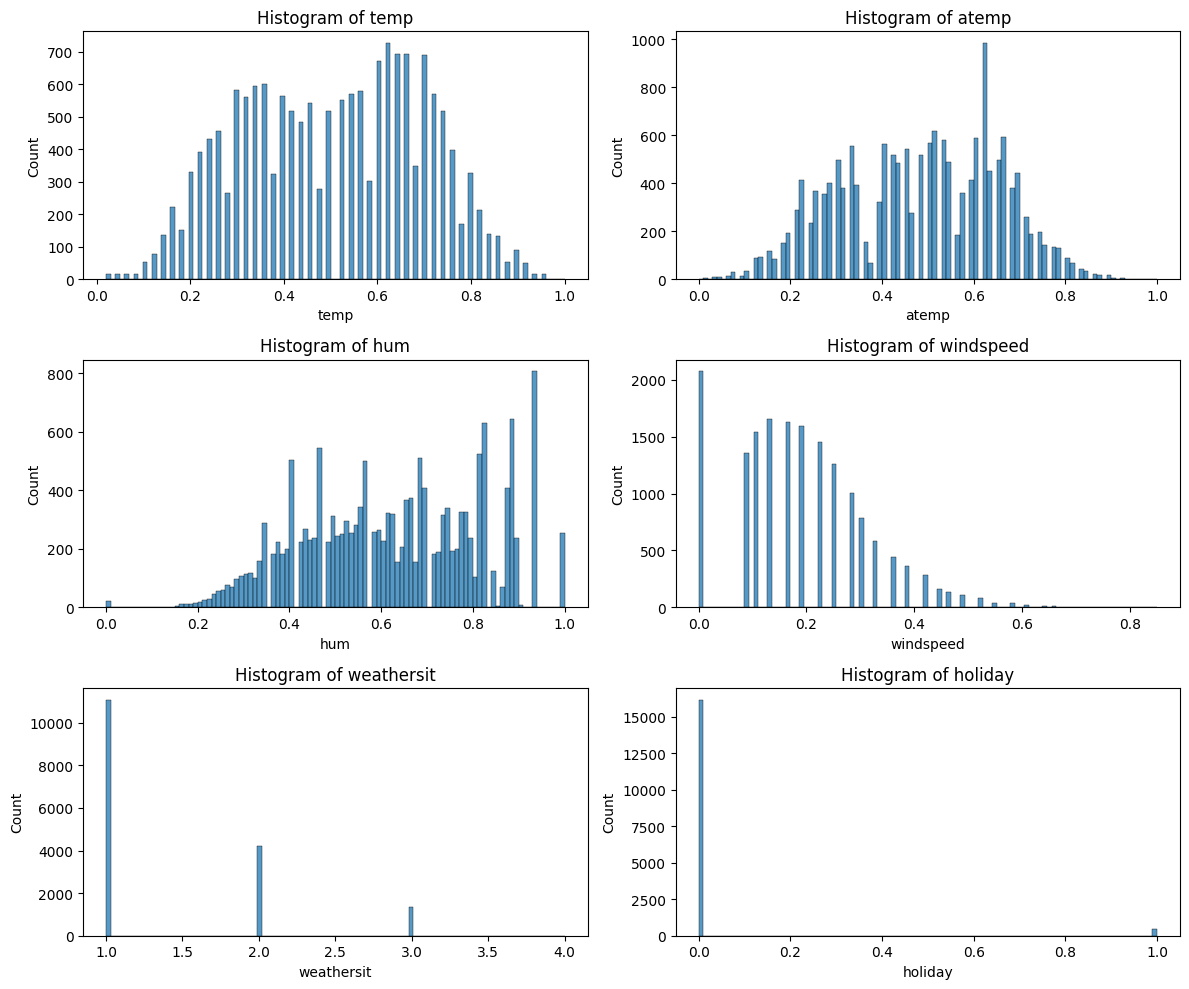

In [13]:
keys = ['temp', 'atemp', 'hum', 'windspeed', 'weathersit', 'holiday']

fig, axes = plt.subplots(3,2 , figsize=(12, 10))

axes = axes.flatten()

for i, key in enumerate(keys):
    sns.histplot(data=train, x=key, bins=100, ax=axes[i])
    axes[i].set_title(f'Histogram of {key}')

plt.tight_layout()
plt.show()

### 1.3.1 Valt hier iets op?

**Correlatiematrix**
- De kolommen 'temp' en 'atemp' zijn zeer sterk gecorreleerd (waarde van 0.99). Dit is vrij logisch, aangezien beide genormaliseerde waardes met betrekking tot de temperatuur bevatten.

- De kolommen 'temp en 'atemp zijn enigzins positief gecorreleerd  (waarde van 0.4 en 0.41) met de 'cnt' kolom. Dit kan erop wijzen dat hogere temperaturen leiden tot een hoger aantal verhuurde producten.

- De 'hum' kolom heeft een negatieve correlatie (waarde van -0.33) met de 'cnt' kolom. Hieruit kan worden afgeleid dat een hogere luchtvochtigheid wellicht een negatieve invloed heeft op het aantal verhuurde producten.

- De 'windspeed' kolom heeft een lichte positieve correlatie (waarde van 0.097) met de 'cnt' kolom. Hieruit valt niet heel veel af te leiden, aangezien de correlatiecoëfficient dicht bij 0 ligt.


**Boxplots**
- 'Weathersit' vs 'cnt': <br>
    De 'weathersit' is ordinaal gemeten. Dit houdt in dat er bij '1' goed weer is en als het richting '4' gaat er slecht weer is (zoals in de kolombeschrijving bovenaan het notebook is beschreven). In de boxplots is te zien dat het aantal verhuurde producten bij '1' vrij hoog is, maar naarmate het richting de '4' gaat steeds verder afneemt. Dit laat zien dat bij slechtere weersomstandigheiden het aantal verhuurde producten lager is.
    
- 'Holiday' vs 'cnt': <br>
    Naast het feit dat er een stuk meer '0' (geen vakantiedag), dan '1' (wel vakantiedag) waardes zijn, zijn er voor de rest geen opvallende dingen in deze grafiek.
    

**Scatterplots**
- Atemp/Temp: <br>
    Het valt op dat bij een hogere temperatuur er meer producten worden verhuurd ten opzichte van een lage temperatuur.

- Hum: <br>
    In deze grafiek is geen duidelijke correlatie / trend te zien.

- Windspeed: <br>
    Vanaf ongeveer 0.3 (genormaliseerde windspeed) is er een enigzins dalende trend in het aantal verhuurde producten.





**Histplots**

- Temp/Atemp: <br>
    Beide kolommen zijn relatief normaal verdeeld. Het valt wel op dat bij de 'atemp' kolom er een piek zit op de 0.6.

- Hum: <br>
    Het is relatief normaal verdeeld, maar het valt wel op dat bij een hogere humidity het aantal verhuurde producten hoger ligt.

- Windspeed: <br>
    Deze grafiek is left skewed. In de grafiek is te zien dat naarmate de windspeed hoger is, het aantal verhuurde producten afneemt.


- Weathersit: <br>
    Ten eerste valt het op dat er bijna geen '4' waardes aanwezig zijn (in totaal 3 na het checken met value_counts). Ook is te zien dat er minder producten worden verhuurd, naarmate de weersomstandigheden verslechteren.

- Holiday: <br>
    Naast het feit dat het aantal vakantiedager lager is dan het aantal niet vakantiedagen (wat logisch is), is het voor de rest niet iets opvallends in de grafiek te zien.

### 1.4 Decompose

Om de gehele data te visualieren wordt hier een lineplot gemaakt van de 'date_hour' kolom ten opzichte van de 'cnt' kolom.

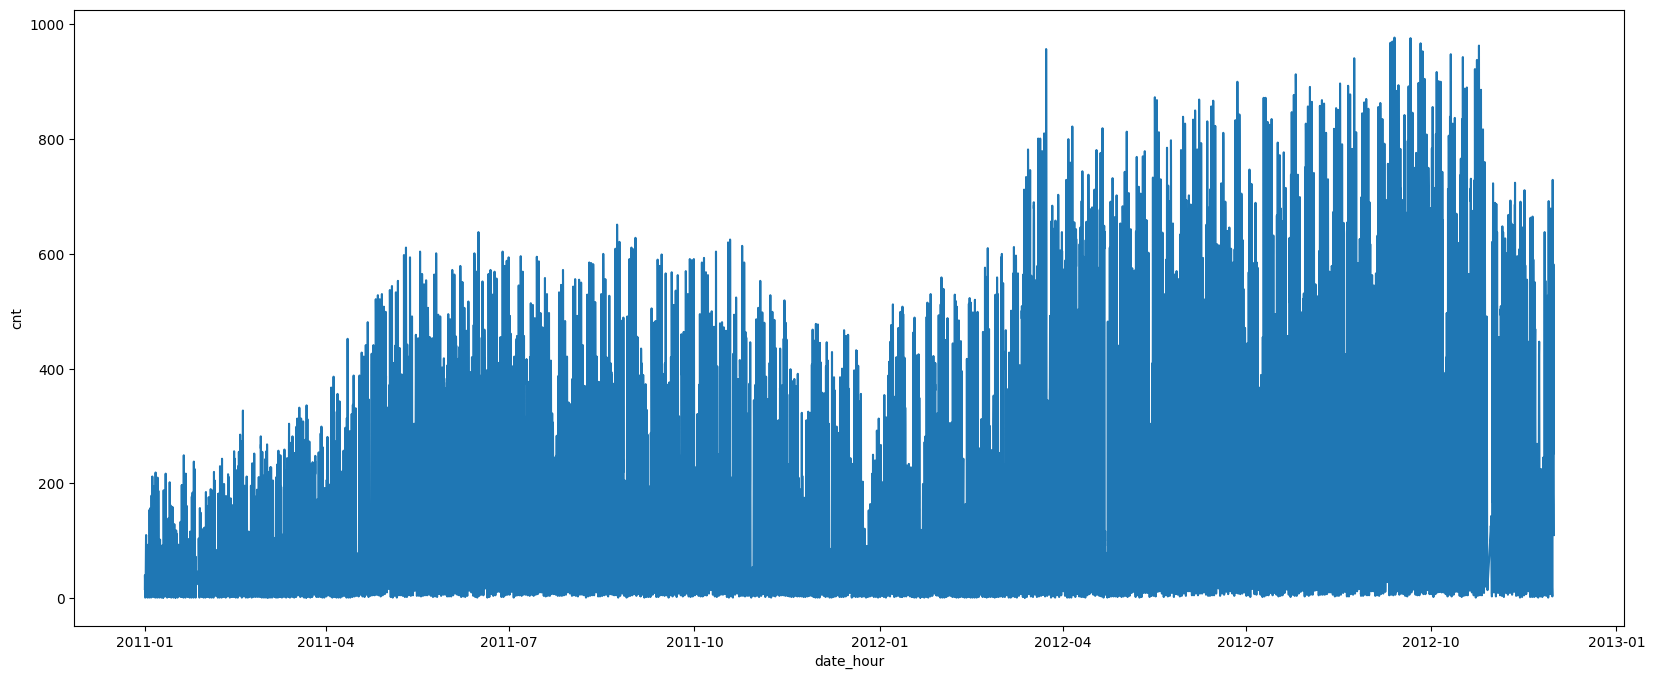

In [14]:
# Lineplot from 'date_hour' vs 'cnt'	
plt.figure(figsize=(20, 8))
sns.lineplot(data=train, x='date_hour', y='cnt')
plt.show()

In [15]:
# 'date_hour' to index
train_decomp = train.set_index('date_hour')
train_decomp = train_decomp['cnt']

In [16]:
# Splitting time to only retain three months of data
split_date = '2011-04-01 00:00:00'
train_decomp_split = train_decomp[:split_date]

In [17]:
# Decomposition of time series
def decompose_ts(series, period=None):


    series_decomp = sm.tsa.seasonal_decompose(series, period=period)
    trend = series_decomp.trend
    seasonal = series_decomp.seasonal
    resid = series_decomp.resid

    return trend, seasonal, resid

trend, seasonal, resid = decompose_ts(train_decomp, period=24)

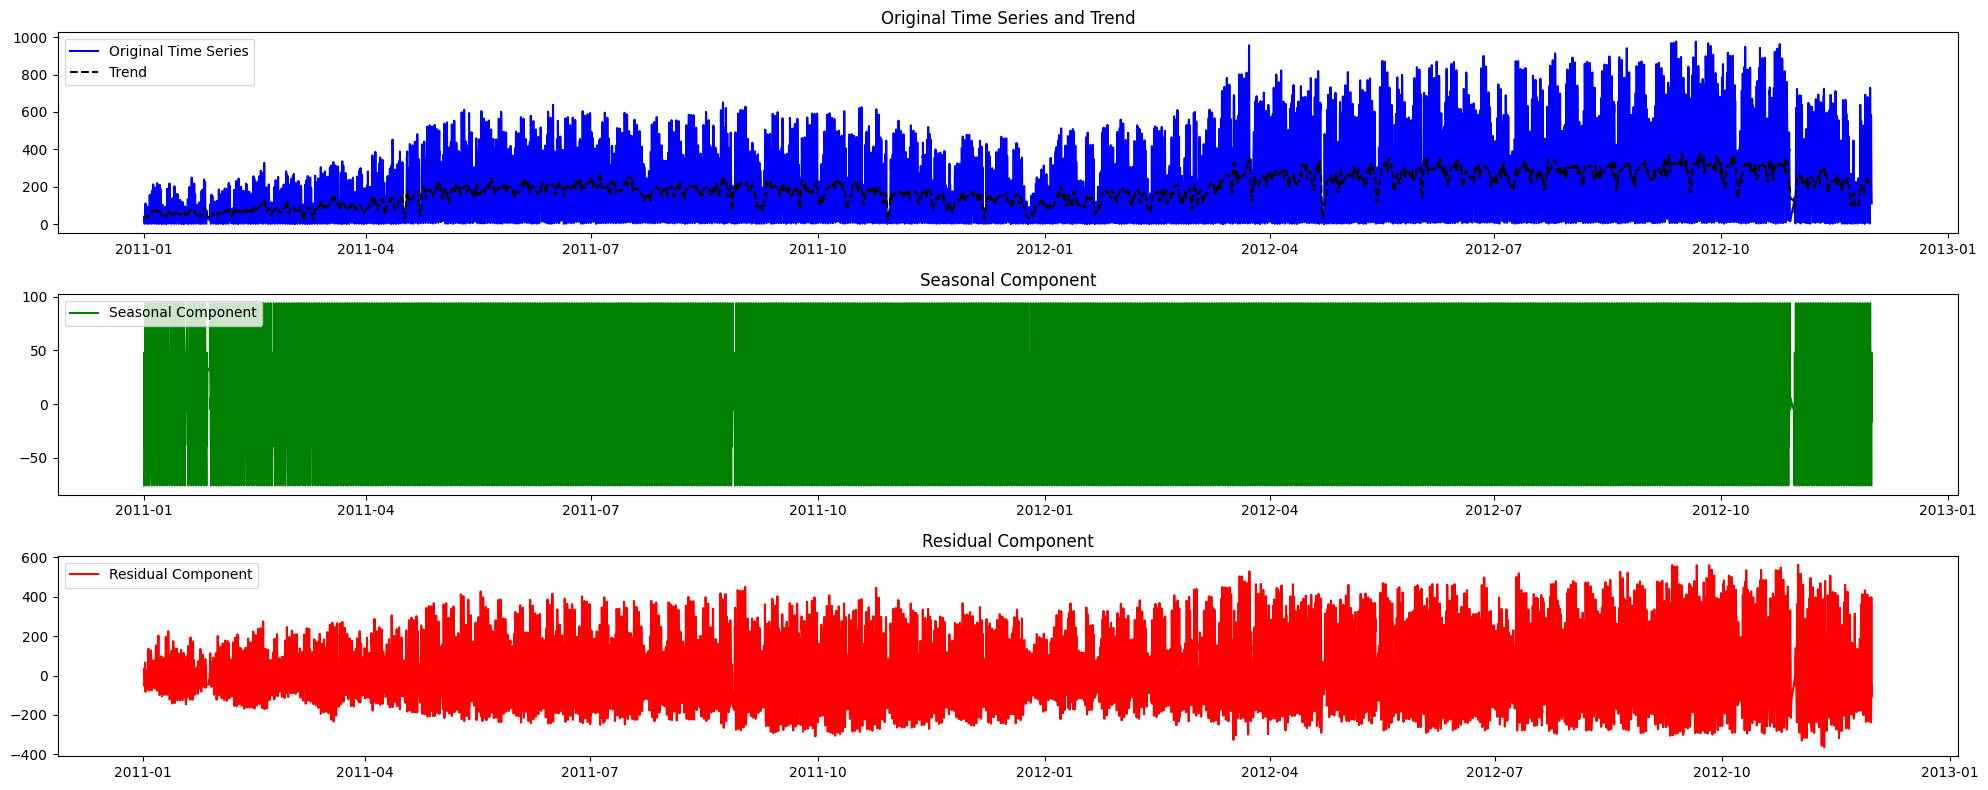

In [18]:
def plot_ts(series, trend, seasonal, residuals):
    """
    Plots the original time series, trend, seasonal, and residual components.

    Parameters:
        series (pandas.Series): Series with a DateTime index representing the original time series.
        trend (pandas.Series): Time series representing the trend component.
        seasonal (pandas.Series): Time series representing the seasonal component.
        residuals (pandas.Series): Time series representing the residual component.
    """

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 8))

    # Plot the original time series and trend
    axes[0].plot(series.index, series, color='blue', label='Original Time Series')
    axes[0].plot(series.index, trend, color='black', linestyle='dashed', label='Trend')
    axes[0].set_title('Original Time Series and Trend')
    axes[0].legend()

    # Plot the seasonal component
    axes[1].plot(series.index, seasonal, color='green', label='Seasonal Component')
    axes[1].set_title('Seasonal Component')
    axes[1].legend()

    # Plot the residual component
    axes[2].plot(series.index, residuals, color='red', label='Residual Component')
    axes[2].set_title('Residual Component')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

plot_ts(train_decomp, trend, seasonal, resid)


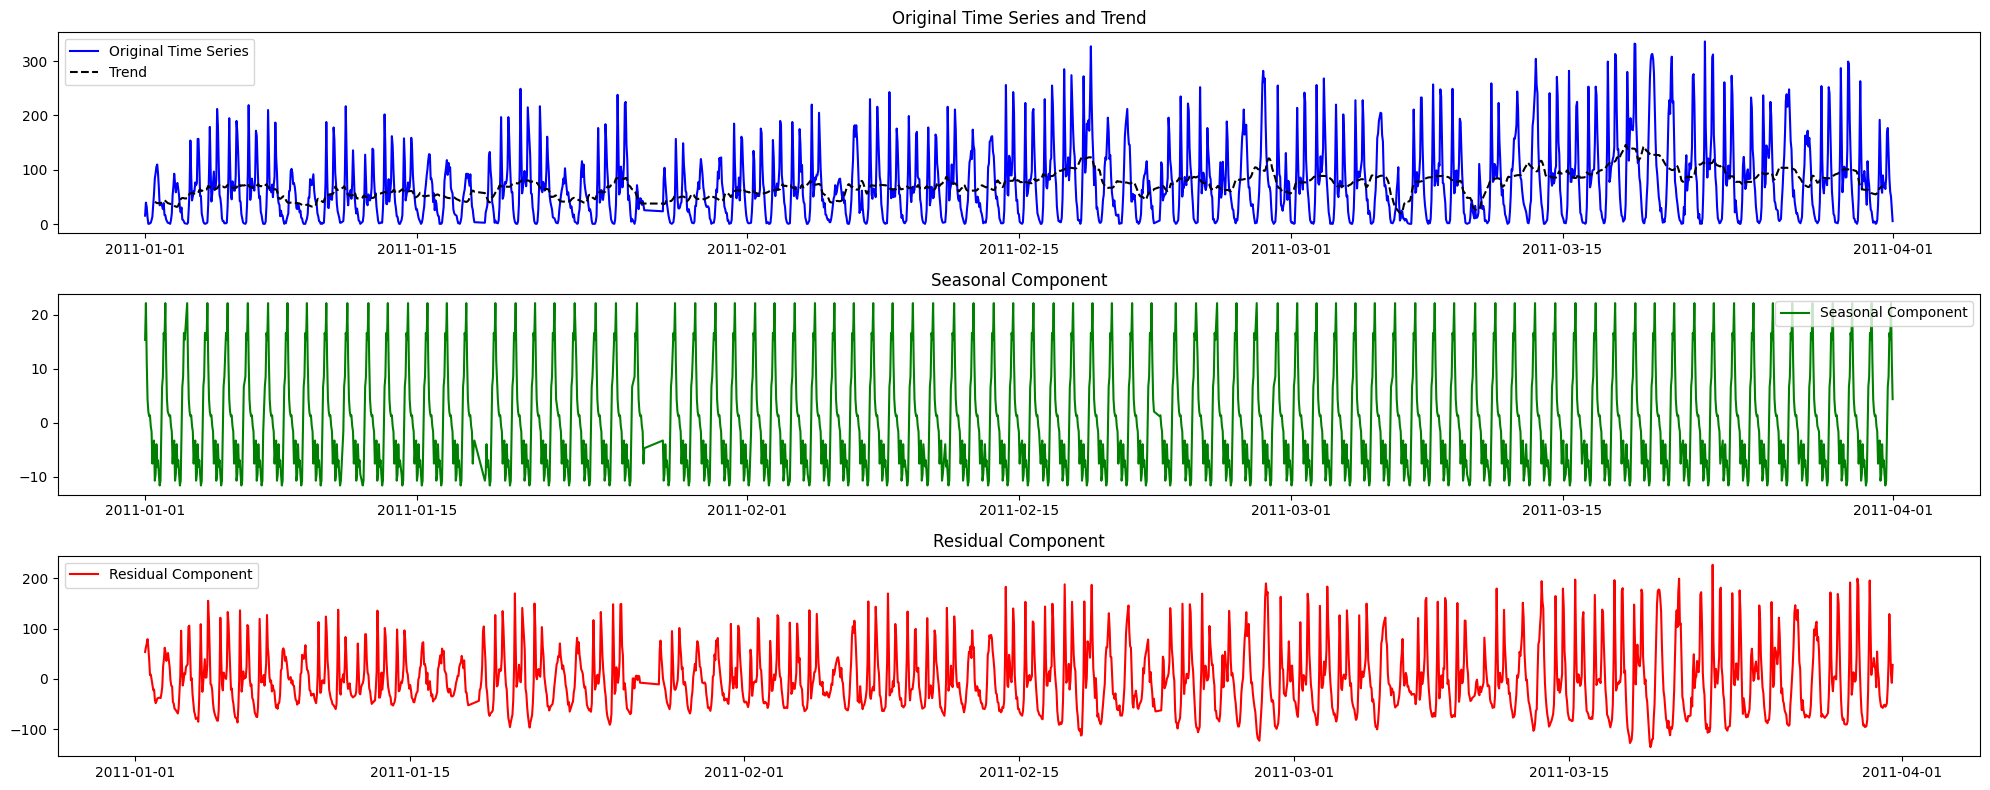

In [19]:
trend2, seasonal2, resid2 = decompose_ts(train_decomp_split, period=24)
plot_ts(train_decomp_split, trend2, seasonal2, resid2)

- Lineplot:

    - In deze grafiek is zowel een stijgende tend als seizoensgebondenheid in de data te zien.

- Decompose:

    Eerst wordt de gehele timeseries degecomposed. Doordat de dataset data bevat over een periode van twee jaar en dit per uur is gemeten, zijn er vrij veel datapunten. In de eerste decompose is enkel de trend goed af te lezen, maar de 'seasonal' grafiek is niet duidelijk. Daarom worden de eerste drie maanden van de data geselecteerd en vervolgens opnieuw gedecomposed om meer duidelijkheid over de seizoensgebondenheid te krijgen.
    
    - Trend: De trendgrafiek laat zien dat er een enigzins stijgende trend is in de data. Dit wordt in zowel de 'trend' grafiek van de decompose als in de orignele lineplot over twee jaar beide duidelijk. 
    - Seasonal: Er is duidelijk sprake van seizoensgebondenheid (per dag).  (Per dag)
    - Residual: Er is nog veel data dat nog niet verklaard is.

## 1.5 Stationariteit controleren en ACF/PACF

Aangezien een 'stationairy' dataset een belangrijke voorwaarde is voor 'ARIMA' timeseries modellen, wordt hieronder de Dickey-Fuller test uitgevoerd om dit te controleren.

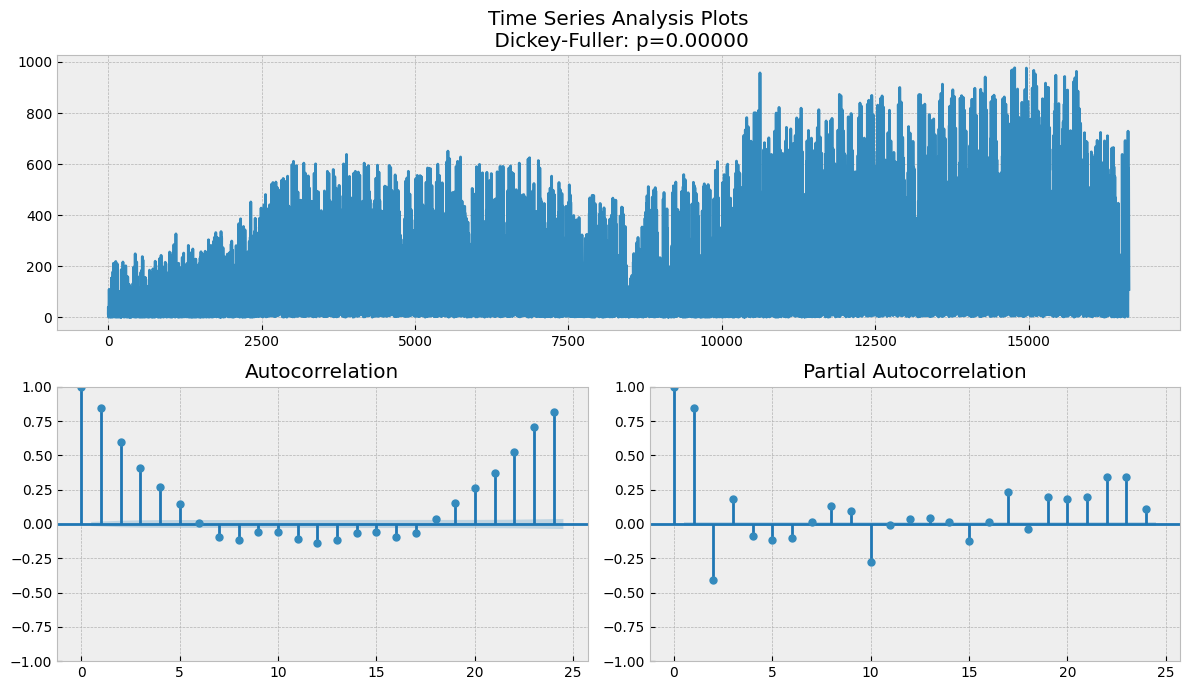

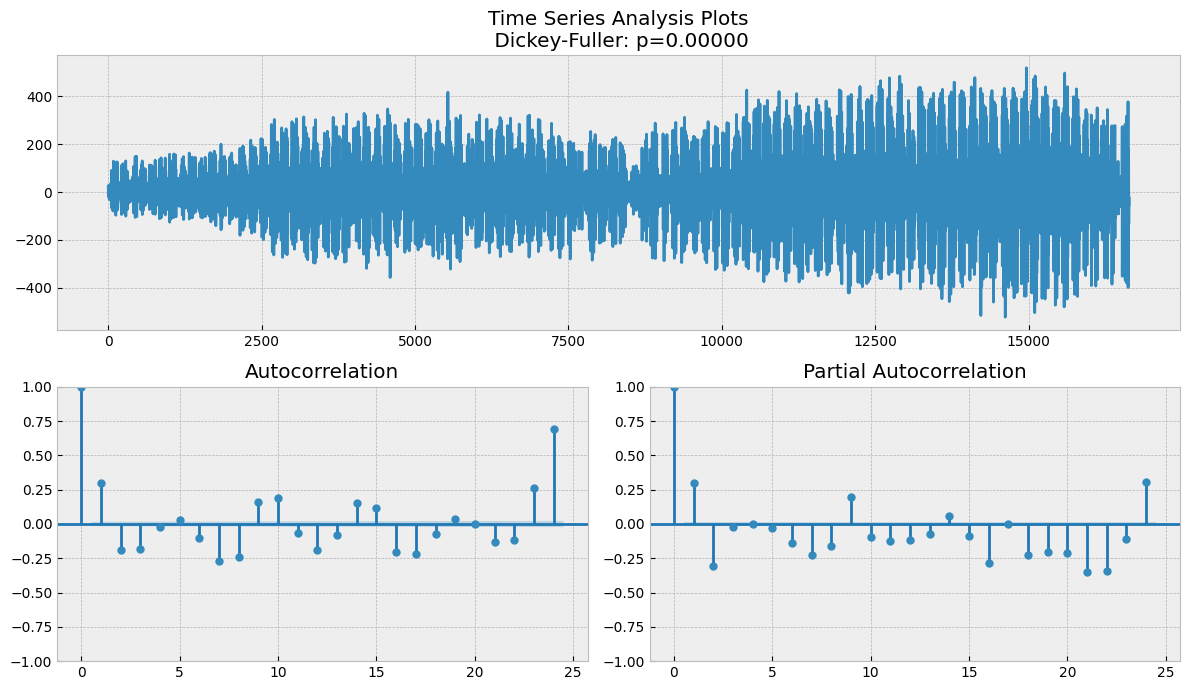

In [20]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(train['cnt'], lags=24)

# Take the first difference to remove to make the process stationary
data_diff = train['cnt'] - train['cnt'].shift(1)

tsplot(data_diff[1:], lags=24)

**Algemene uitleg ACF & PACF**

ACF:

- Hier wordt gekeken naar de correlatie tussen de huidige lag en alle voorgaande lags ten opzichte van Y. Dit wordt geplot in een grafiek wat ook duidelijk maakt of deze correlaties positief of negatief zijn.

PACF:

- Hier wordt enkel gekeken naar de correlatie tussen één eerdere lag ten opzichte van Y. Alle tussenliggende lags hebben dus geen invloed op de PACF.


**ACF & PACF op onze dataset**

ACF:

- In de grafiek is te zien dat de eerste vijf lags een relatief hoge correlatie hebben met de Y waarde. Dit neemt echt wel af. De dertien lags daarna tonen aan dat ze weer een hele lage correlatie hebben en vervolgens is er in de opvolgende zes lags weer een stijging in de correlatie. 

Dit zou kunnen aantonen dat er iets van een patroon in de data aanwezig is, ondanks het stationairy is.

PACF

- Hierin is te zien dat de eerste lag een relatief hoge positieve correlatie heeft met de Y waarde. De tweede lag heeft een iets lager (maar alsnog significante) negatieve correlatie met de Y waarde. Hierna zijn eigenlijk alle correlaties onder de 0.25. Ondanks ze niet in een blauwe "errorbar" staan, is er besloten dat we deze niet relevant genoeg vinden om mee te nemen in de time series modellen.

Bij het gebruiken van de time series modellen zullen er dus twee lags worden meegenomen in de parameters. 

In [21]:
series = train['cnt']

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(series)

# Print the test results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -6.625164793721729
p-value: 5.901288668679143e-09
Critical Values:
   1%: -3.430744160906401
   5%: -2.8617142032973706
   10%: -2.5668627239973634


Uit de test komt een p-value van 5.90e-09, wat betekent dat de data stationairy zou moeten zijn. Kijkend naar de plots van de decompose ziet het er alleen niet stationairy uit. Dit komt doordat er een trend / seasonal component te zien is. Dit is raar, dus we weten niet of we het stationairy moeten maken.

## 1.6 Beschrijf wat de belangrijkste bevindingen zijn van de EDA

Er zijn veel inzichten gekomen uit de EDA. Hieronder zullen de belangrijkste kort worden toegelicht:

- In de visualisaties van toevoegde time series kolommen is te zien dat er duidelijke pieken zijn van verhuuraantallen om 8:00 en 18:00, maar ook dat er op de zondag aanzienlijk minder wordt verhuurd. Daarnaast zijn de aantal in de zomer een stuk hoger vergeleken die in de winter.

- In de correlatiematrix is naarboven gekomen dat 'temp' en 'atemp' een positieve invloed hebben op het aantal verhuuraantallen, terwijl 'hum' een negatieve correlatie ermee heeft. 

- De boxplots laten zien dat er geen duidelijk verband is tussen 'holiday' en de verhuuraantallen, maar dat er bij slechtere weeersomstandigheden ('weathersit'), wel een aanzienlijk dalende trend is. 

- Kijkend naar de histogrammen bevat de dataset geen rare / extreme outliers waar iets aan gedaan moet worden.

- Bij het decomposen van de data is het opgevallen dat er een licht stijgende lijn is in de verhuuraantallen over de twee jaar heen. Ook valt het op dat er een (dagelijks) periodiek patroon te zien is. 

- De Fourier-analyse heeft periodieke patronen geïdentificeerd, waarbij jaarlijkse, dagelijkse en de 12-uurlijkse de dominante frequenties waren.

- De P-value die uit de Dickey-Fuller test komt, toont aan dat de data stationair is, maar kijkend naar de grafieken valt het toch op dat er een duidelijke trend en seasonal component aanwezig was. Om zeker te zijn dat de data stationary is, voordat we gaan modelleren, is dit voor de zekerheid nog gedaan d.m.v. first order differencing.

- Er is een dalende en stijgende lijn in de ACF, wat aan kan tonen dat er toch patronen in de data aanwezig zijn. IN de PACF grafiek is er te zien dat de eerste twee lags de grootste invloed hebben op de Y waarde, waardoor er is besloten om die mee te nemen in de time series modellen.

# 2. Data-voorbereiding

## 2.1 Verwijder indien nodig niet relevante kolommen

In [22]:
train = train.drop(columns=['dayName', 'month'])
test = test.drop(columns=['dayName', 'month'])

In [23]:
display(train.head())
display(test.head())

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,day,week,weekend,season
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,0,5,52,1,1
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,1,5,52,1,1
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2,5,52,1,1
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,3,5,52,1,1
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,4,5,52,1,1


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,hour,day,week,weekend,season
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,5,48,1,1
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,48,1,1
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,5,48,1,1
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,5,48,1,1
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,5,48,1,1


### 2.1.1 Leg uit waarom deze wel of niet verwijderd zijn

- Dayname:

    Deze kolom wordt verwijderd aangezien het geen 'int' of 'float' is en het praktisch dezelfde data weergeeft als de 'day' kolom.

- Month:

    Deze kolom wordt verwijderd, omdat het hetzelfde laat zien als de 'week' kolom, maar de 'week' kolom heeft in dit geval meer waardes. Hierom hebben we besloten om deze van de twee te behouden. DOor de 'month' kolom te verwijderen, zorgen we er ook voor dat er geen sprake is multicollineariteit. 

## 2.2 Vul eventuele missende waarden in of verwijder ze. Voor time series kan interpolatie een nuttige methode zijn.

In [104]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   16637 non-null  datetime64[ns]
 1   holiday     16637 non-null  int64         
 2   weathersit  16637 non-null  int64         
 3   temp        16637 non-null  float64       
 4   atemp       16637 non-null  float64       
 5   hum         16637 non-null  float64       
 6   windspeed   16637 non-null  float64       
 7   cnt         16637 non-null  int64         
 8   hour        16637 non-null  int32         
 9   day         16637 non-null  int32         
 10  week        16637 non-null  UInt32        
 11  weekend     16637 non-null  int64         
 12  season      16637 non-null  int64         
dtypes: UInt32(1), datetime64[ns](1), float64(4), int32(2), int64(5)
memory usage: 1.5 MB


None

### 2.2.1 Leg uit waarom er voor wat gekozen is

Doordat er geen missende waardes zijn, hoeven hier ook geen aanpassingen voor worden gedaan.

## 2.3 Kijk of er outliers zijn

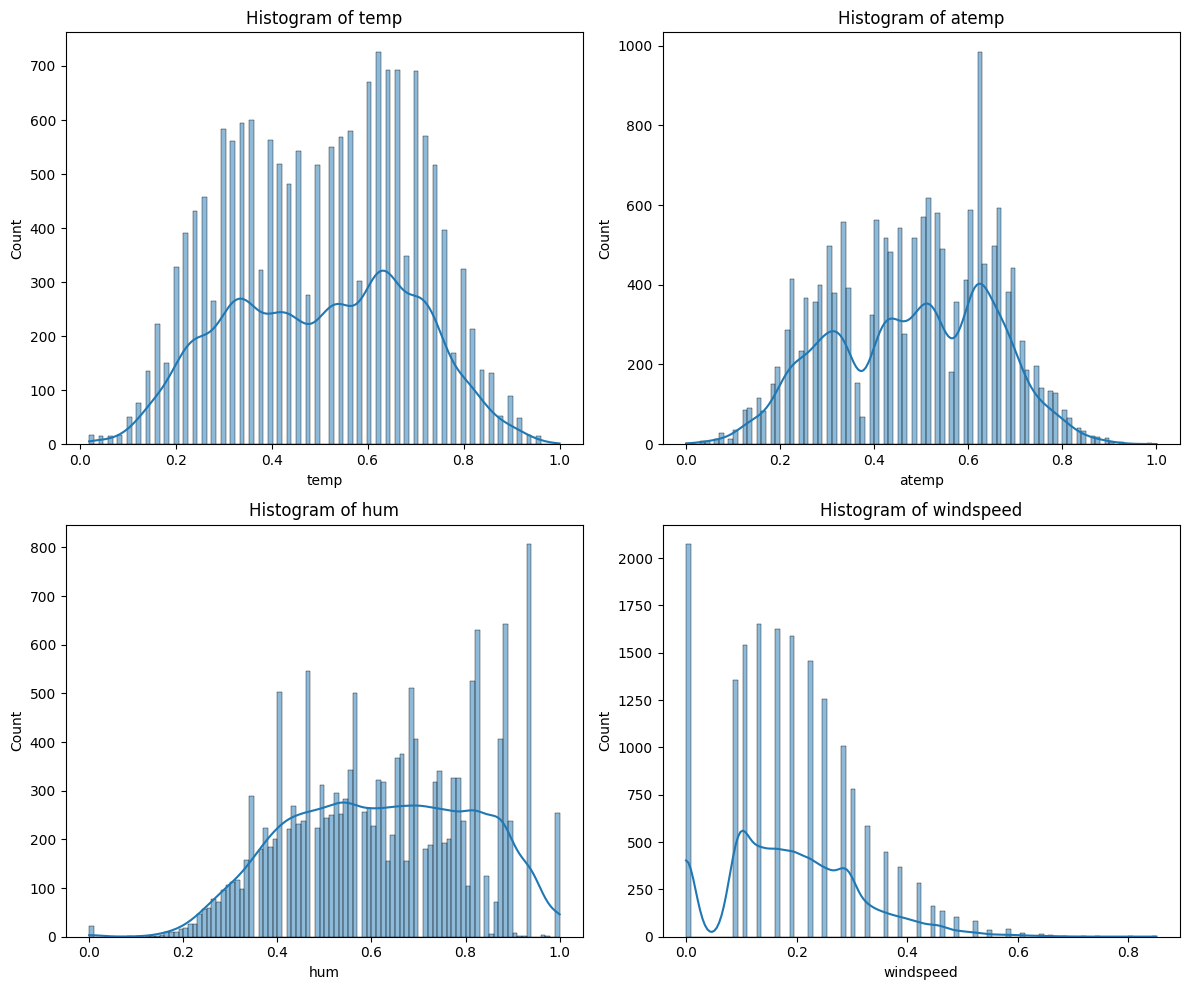

In [24]:
keys = ['temp', 'atemp', 'hum', 'windspeed']

fig, axes = plt.subplots(2,2 , figsize=(12, 10))

axes = axes.flatten()

for i, key in enumerate(keys):
    sns.histplot(data=train, x=key, bins=100, ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {key}')

plt.tight_layout()
plt.show()


### 2.3.1 Verwijder of corrigeer deze indien nodig

Er is besloten om geen aanpassingen te doen aan de dataset.

### 2.3.2 Leg uit waarom deze keuze is gemaakt

- Temp:

    Temp is een normaal verdeling en heeft geen outliers.
    
- Atemp:

    Atemp is ook relatief normaal verdeeld en heeft geen extreme outliers.

- Hum:

    Hum is vrij left skewed, we zien geen grote outliers.

- Windspeed:

    Windspeed is duidelijk right skewed, het heeft een vrij lange staart maar neemt gelijdelijk af wat vrij reëel is.


Aangezien er niet extreem rare waardes in de dataset staan, is er dus besloten om geen aanpassingen te maken.


## 2.4 Schaal/normaliseer de data indien nodig

Er is besloten om niet te schalen of normaliseren. Zie reden hieronder:

### 2.4.1 Leg uit waarom voor deze methode is gekozen

De numerieke kolommen zijn al genormaliseerd, deze zijn dus al op dezelfde schaal. Dit is dus niet nogmaals nodig. De overige kolommen worden later veranderd naar dummy kolommen. Deze veranderen dus ook naar booleans, dit zorgt ervoor dat het op de zelfde schaal is, ook zorgt dit ervoor dat categorien zoals de dagen van de week niet worden gezien als een grotere waarde van elkaar. Dag 2 in de week is niet 2 keer zo veel waard als dag 1.

## 2.5 Data sampling indien nodig

Er is besloten om niet te samplen. Zie reden hieronder:

### 2.5.1 Leg uit waarom dit wel/niet nodig is en welke methode wordt gebruikt

We over- of undersamplen de data niet, we hebben te maken met time series data en de continuïteit is hier erg belangrijk. Door het under samplen zouden we hier data uithalen en bij oversampelen zouden we hier neppe data toevoegen, beide zouden de continuïteit kunnen breken en zowel onze analysis als onze modellen in de weg kunnen zitten.

# 3. Time series feature engineering

## 3.1 Voeg tijdserie features toe aan de dataset

Er zijn eerder in het notebook timeserie features toegevoegd aan de dataset. Dit is in de EDA gedaan, aangezien er tijdens de EDA ook grafieken zijn geplot aan de hand van deze features om er een beter inzicht in te krijgen. Kijk hiervoor in hoofdstuk 1.2.

## 3.2 Onderzoek wat de de invloed is van deze features, samen met de andere features, op de voorspellingen

### 3.2.1 Onderzoek naar seizoenspatronen met Fourier analyse

Peaks found at [   2  692  694 1387]


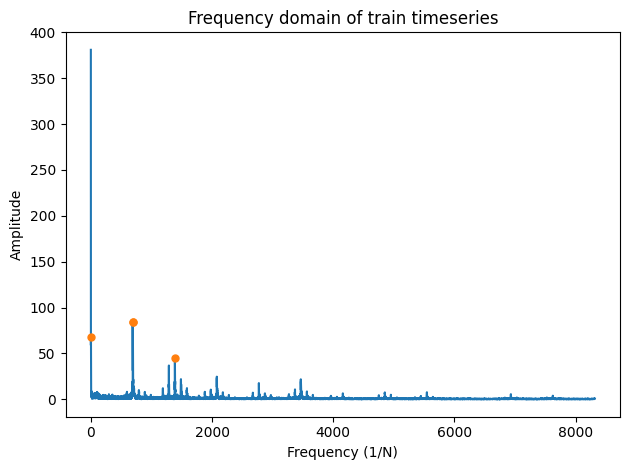

In [34]:
# Calculate the number of samples in the timeseries
N = len(train)

# Compute the Fourier transform of the timeseries
train_ft = np.fft.fft(train['cnt'])

# Compute the magnitude of the frequencies
magnitude = 2.0/N * np.abs(train_ft[:N//2])

peaks, _ = find_peaks(magnitude, height=40)

print(f"Peaks found at {peaks}")

# Plot the constituent frequencies
plt.plot(magnitude)
plt.xlabel('Frequency (1/N)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of train timeseries")

plt.plot(peaks, magnitude[peaks], ".", markersize=10)

#plt.xlim(1250, 1500)
plt.tight_layout()
plt.show()

#### 3.2.2 Leg uit hoe het werkt en wat er is gevonden

De pieken in de frequenties staan op 2, 692/694 en 1387.

Formule periode is totale lengte / frequentie.

De periodes die hierbij horen zijn:

Frequentie 2: 16637/2 = 8318.5 uur (bijna één jaar).

Frequentie 692/694: 16637/692 = (ongeveer) 24 uur.

Frequentie 1387: 16637 / 1387 = 12 uur.

**Bevindingen**

Door het toe te passen van de fourier analyse op onze data zien we een duidelijk periodiek patroon terugkomen, deze vallen op de frequenties de gelijkstaan aan jaarlijks (freq ~2), dagelijks (freq ~692), 12 uurlijks (freq ~1387). Dit zijn dus ook de dominante frequenties in de grafiek.


**Algemene uitleg werking fourier analyse**

Bij een Fourieranalyse wordt een wiskunde techniek toegepast die een time series omzet van het 'tijdsdomein' naar het 'frequentiedomein'. Dit houdt in dat een complexe time series wordt ontleedt in de samenstellende onderliggende periodieke signalen. Met behulp van deze analyse kunnen de verschillende periodieke signalen in één nieuwe timeseries grafiek worden geïdentificeerd. 


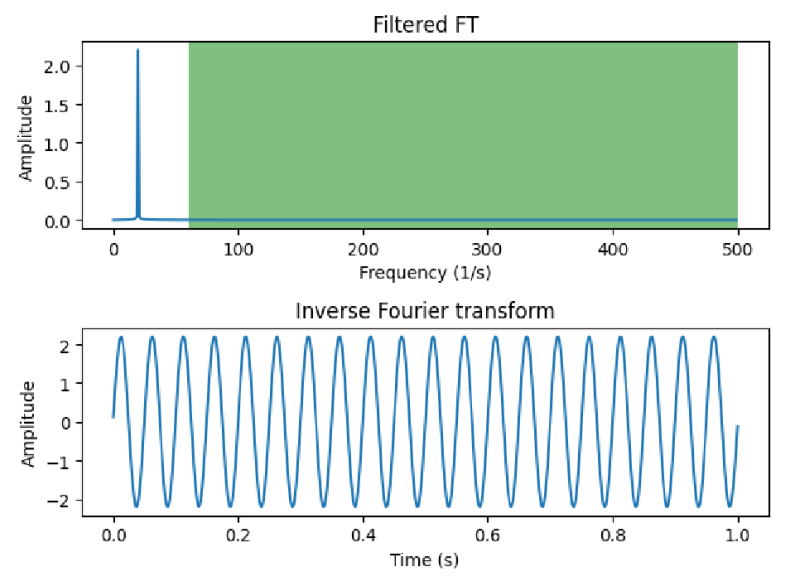


Het biedt verschillende inzichten:
- Het laat zien welke cyclische patronen er in de data zitten (wekelijkse, maandelijkse, jaarlijkse trend etc.).
- Aan de hand van de amplitude kan je zien welke frequenties het meest dominant zijn in de timeseries.
- Het geeft mogelijkheden tot een trendanalyse. Als een signaal wordt gedomineerd door lage frequenties, betekent dat dat er langzame trends zijn. Hoge frequenties geven aan dat er snelle fluctuaties zijn.

Om een beter model te creëren is er ook nog een 'inverse fourier-transformatie'.  Hiermee kan je bepaalde (niet relevante) frequenties uit de timeseries verwijderen. 

Er zijn verschillende manieren om dit te doen:
- Low-pass filter -> hiermee behoudt je lage frequenties (en verwijder je juist hoge frequenties) om snelle, ongewenste fluctuaties te verwijderen en langzame trends te behouden.
- High-pass filter -> hiermee behoudt je hoge frequenties (en verwijder je juist de lage frequenties) om snelle veranderingen in het signaal te behouden en langzame trends te verwijderen.
- Bandstop filter - > dit onderdrukt een bepaalde frequentieband in de grafiek, terwijl het de rest van de frequenties behoudt.
- Bandpass filter -> dit laat juist een bepaalde frequentieband in de grafiek zien, terwijl het zowel lage als hoge frequenties verwijderd.
- Noise filter -> dit verwijdert de ruis in een signaal.

**Onze analyse**

We zien een paar periodieke signalen duidelijke terugkomen, 


### 3.2.3 Onderzoek naar trends

In [26]:
temp_X = train.drop(columns=['cnt'])
temp_y = train['cnt']

In [27]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(temp_X, temp_y, test_size=19*24, shuffle=False, random_state=456)

In [28]:
for order in range(1,6):
    dp = DeterministicProcess(index=y_train_t.index, constant=False, order=order, drop=True)
    X_train_t = dp.in_sample()
    X_test_t = dp.out_of_sample(steps=len(y_test_t))
    model = LinearRegression()
    model.fit(X_train_t, y_train_t)
    y_pred = model.predict(X_train_t)
    y_fore = model.predict(X_test_t)
    r2_train = r2_score(y_train_t, y_pred)
    r2_test = r2_score(y_test_t, y_fore)
    print('order: ', order)
    print(r2_train, r2_test)
    print(model.coef_)

order:  1
0.10822627108134786 -0.3346139568787925
[0.01283752]
order:  2
0.10865026634396513 -0.3987216544696419
[9.72532173e-03 1.92324992e-07]
order:  3
0.11303777410176286 -0.7237691606561278
[ 3.34188996e-02 -3.46804544e-06  1.50800084e-10]
order:  4
0.13669485946686366 -0.042045868175963896
[ 1.37405394e-01 -3.23832336e-05  2.93032382e-09 -8.58831913e-14]
order:  5
0.13669485946686366 -0.042045868175963896
[ 1.37405394e-01 -3.23832336e-05  2.93032382e-09 -8.58831913e-14]


In [29]:
def time_series_data( order, constant=False, drop=True):
        dp = DeterministicProcess(index=y_train_t.index, constant=constant, order=order, drop=drop)
        X_train2 = dp.in_sample()
        X_test2 = dp.out_of_sample(steps=len(y_test_t), forecast_index=y_test_t.index)
        return X_train2, X_test2

X_train2, X_test2 = time_series_data(1)
display(X_train2.head())
display(X_test2.head())

,trend
0,1.0
1,2.0
2,3.0
3,4.0
4,5.0


,trend
16181,16182.0
16182,16183.0
16183,16184.0
16184,16185.0
16185,16186.0


#### 3.2.4 Leg uit hoe het werkt en wat er is gevonden

Als je kijkt naar de testset r2 scores, dan zou het gebruiken van order 4 het best zijn. Uit de uitleg eerder dit jaar is gebleken dat order 1 en 2 voornamelijk voorkomen, terwijl order 3 en 4 vrijwel nooit gebruikt worden. Ook is er te zien dat de r2 score verslechterd bij elke hogere order en dan ineens een heel stuk wordt verbeterd bij order 4. Dit is een raar patroon wat we niet kunnen verklaren. Daarnaast betekent order 4 dat het zo slecht generaliseerd dat het niet waard is om te gebruiken, dit zorgt voor extreme waardes waar het model niet goed op gefit kan worden .Hierom is er besloten om dan toch order 1 te gebruiken, aangezien dit degene is met de 'minst slechte' r2 score van de drie. 

### 3.2.5 Onderzoek naar cycli en autocorrelatie

Dit is beschreven in hoofdstuk 1.5 in combinatie met stationariteit. Dit zal hier dus niet nogmaals worden uitgelegd.

### 3.2.7 Onderzoek naar andere tijdsgebaseerde features

*denk hier bijvoorbeeld aan:

- lags: Vertragingen in de tijd (bijv. de waarde van vorige dag).
- Rolling statistics: Gemiddelden of varianties over een bepaald venster.
- Datumgerelateerde features: Dag van de week, maand, seizoenen, feestdagen, enz.

### Feature 1 cyclische representatie

In [35]:
def add_cyclic_features(df, time_col, periods, prefix="hour"):
    
    for period in periods:
        sin_col_name = f"sin_{prefix}_{period}"
        cos_col_name = f"cos_{prefix}_{period}"
        
        df[sin_col_name] = np.sin(2 * np.pi * df[time_col] / period)
        df[cos_col_name] = np.cos(2 * np.pi * df[time_col] / period)
    
    return df

train = add_cyclic_features(train, time_col="hour", periods=[24, 12, 8318], prefix="hour")
display(train.head())

test = add_cyclic_features(test, time_col="hour", periods=[24, 12, 8318], prefix="hour")
display(test.head())


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,hour,day,week,weekend,season,sin_hour_24,cos_hour_24,sin_hour_12,cos_hour_12,sin_hour_8318,cos_hour_8318
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,0,5,52,1,1,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,1,5,52,1,1,0.258819,0.965926,0.500000,8.660254e-01,0.000755,1.000000
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2,5,52,1,1,0.500000,0.866025,0.866025,5.000000e-01,0.001511,0.999999
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,3,5,52,1,1,0.707107,0.707107,1.000000,6.123234e-17,0.002266,0.999997
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,4,5,52,1,1,0.866025,0.500000,0.866025,-5.000000e-01,0.003021,0.999995


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,hour,day,week,weekend,season,sin_hour_24,cos_hour_24,sin_hour_12,cos_hour_12,sin_hour_8318,cos_hour_8318
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,0,5,48,1,1,0.000000,1.000000,0.000000,1.000000e+00,0.000000,1.000000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,48,1,1,0.258819,0.965926,0.500000,8.660254e-01,0.000755,1.000000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2,5,48,1,1,0.500000,0.866025,0.866025,5.000000e-01,0.001511,0.999999
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,3,5,48,1,1,0.707107,0.707107,1.000000,6.123234e-17,0.002266,0.999997
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,4,5,48,1,1,0.866025,0.500000,0.866025,-5.000000e-01,0.003021,0.999995


#### 3.2.8 Leg uit hoe het werkt en wat er is gevonden

**Cyclische representatie toevoegen**

We hebben hier de Cyclische representatie toegevoegd op de top 3 frequenties uit de fourier analyse. Dis zijn de (ongeveer) jaarlijkse, dagelijkse en 12-uurlijkse frequenties (zie hoofdstuk 3.2.2.).

Bij tijdreeksanalyse en -modellering is het vaak cruciaal om de herhalende patronen (cycli) in de data te herkennen en effectief te gebruiken. Veel tijdsgerelateerde kenmerken, zoals dagen van de week, maanden van het jaar of uren van de dag, hebben een cyclische aard. Cyclische representaties, gebaseerd op sinus en cosinus, maken het mogelijk om deze patronen op een consistente manier vast te leggen.

## 3.3 Maak duidelijk hoe jullie tot de uiteindelijke keuze voor de features en model(len) zijn gekomen. Wat is er allemaal geprobeerd?

# 4. Train-test splitsing en validatie

*Cross-validation voor time series: Bij time series data kun je geen willekeurige splitsing gebruiken. Gebruik TimeSeriesSplit uit scikit-learn om met opeenvolgende perioden te valideren, of werk met 'rolling' en 'expanding' vensters.

## 4.1 splits de data

In [114]:
# turning date_hour into the index to work with the time series
train.set_index('date_hour', inplace=True)


In [115]:
models_dict = {'lr': LinearRegression(),
               'dt': DecisionTreeRegressor(),
               'rf': RandomForestRegressor(max_depth=10, random_state=42, n_jobs=-1),
               'knn': KNeighborsRegressor(),
               'xgb': XGBRegressor(),
               }

Voor combineren features:
train RMSE lr: 108.41374545321887
test RMSE lr: 136.51624089381372
train RMSE dt: 1.3900795139010391
test RMSE dt: 128.58701028083266
train RMSE rf: 60.90200686517198
test RMSE rf: 115.64592383254904
train RMSE knn: 67.59698583148182
test RMSE knn: 86.70379546564352
train RMSE xgb: 42.93846577778941
test RMSE xgb: 117.573797740155
Na combineren features:
train RMSE lr: 100.2709294180384
test RMSE lr: 113.40377423288136
train RMSE dt: 0.0
test RMSE dt: 131.36792321567697
train RMSE rf: 35.95101485900971
test RMSE rf: 99.30189083906141
train RMSE knn: 69.51251047862732
test RMSE knn: 250.93685700531057
train RMSE xgb: 24.362242624437147
test RMSE xgb: 95.11780511180066


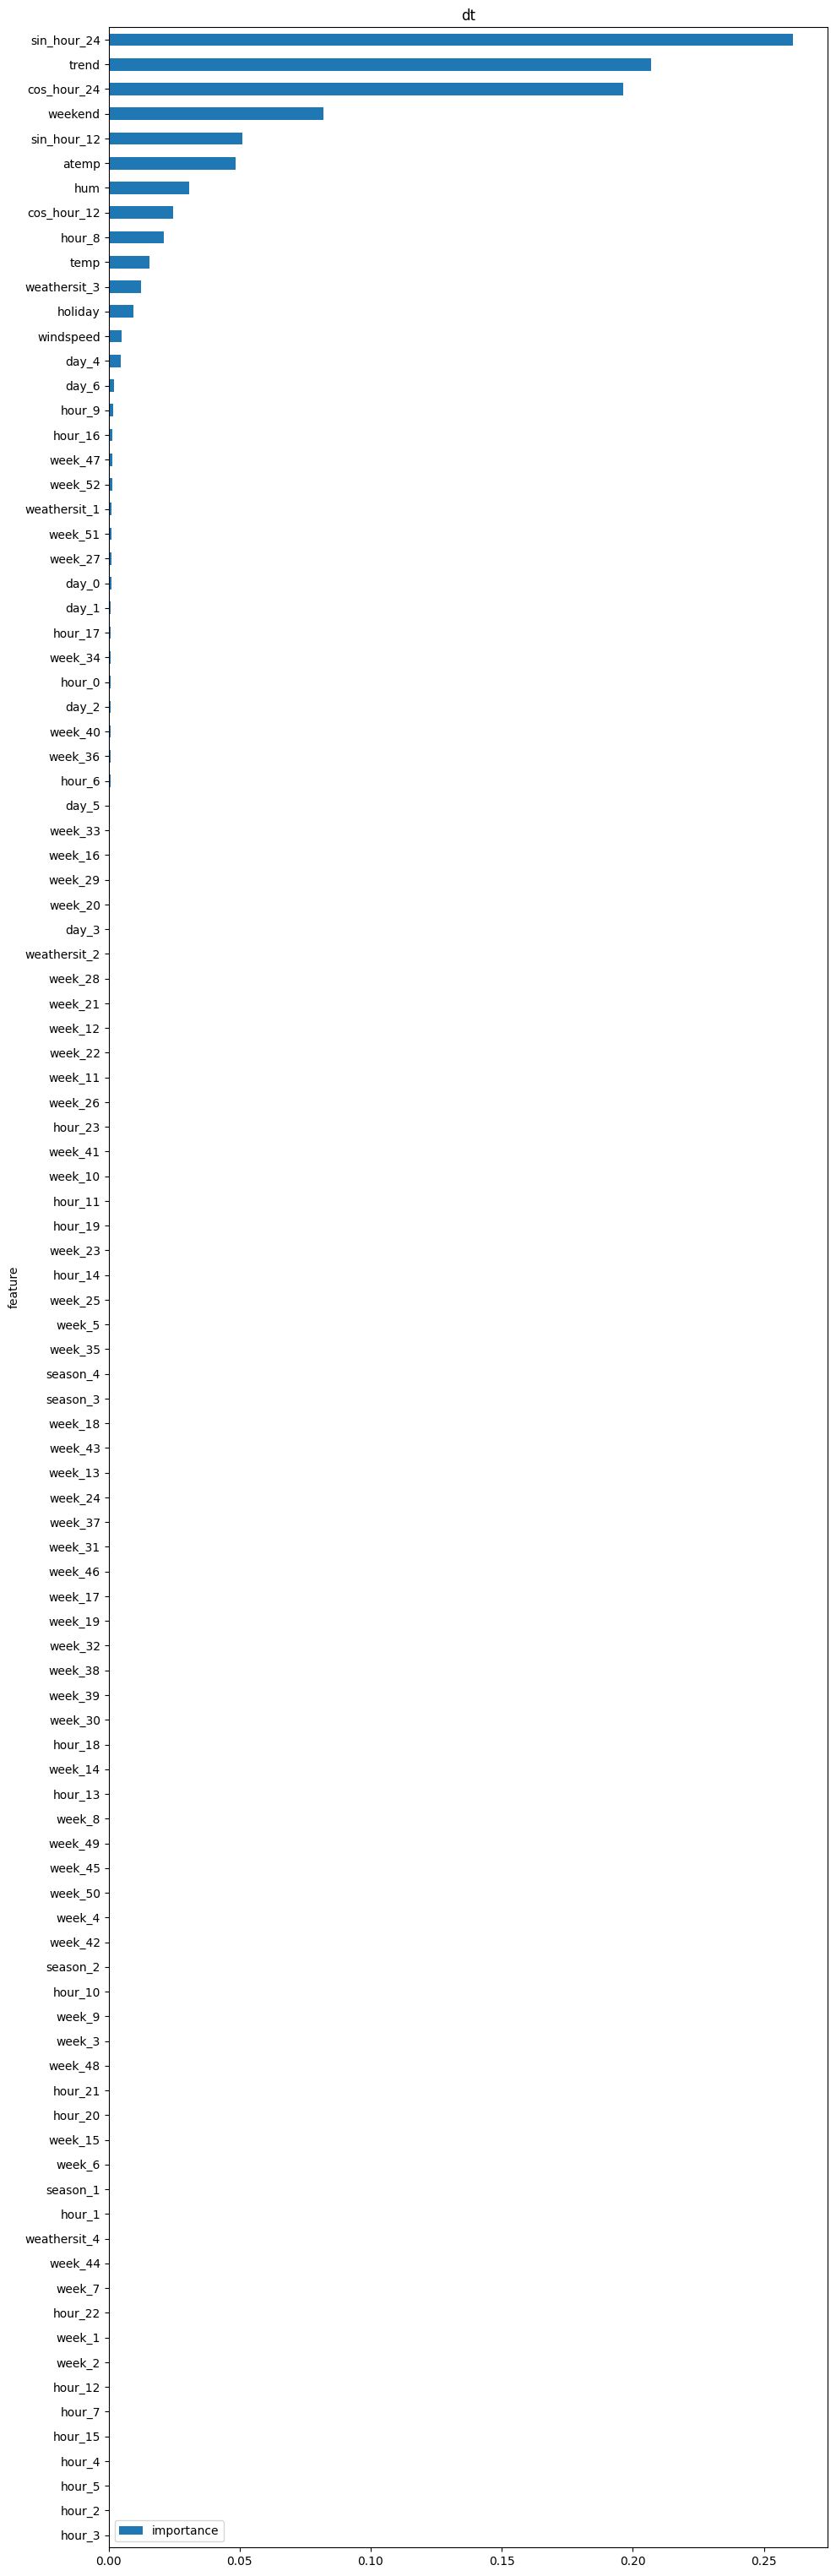

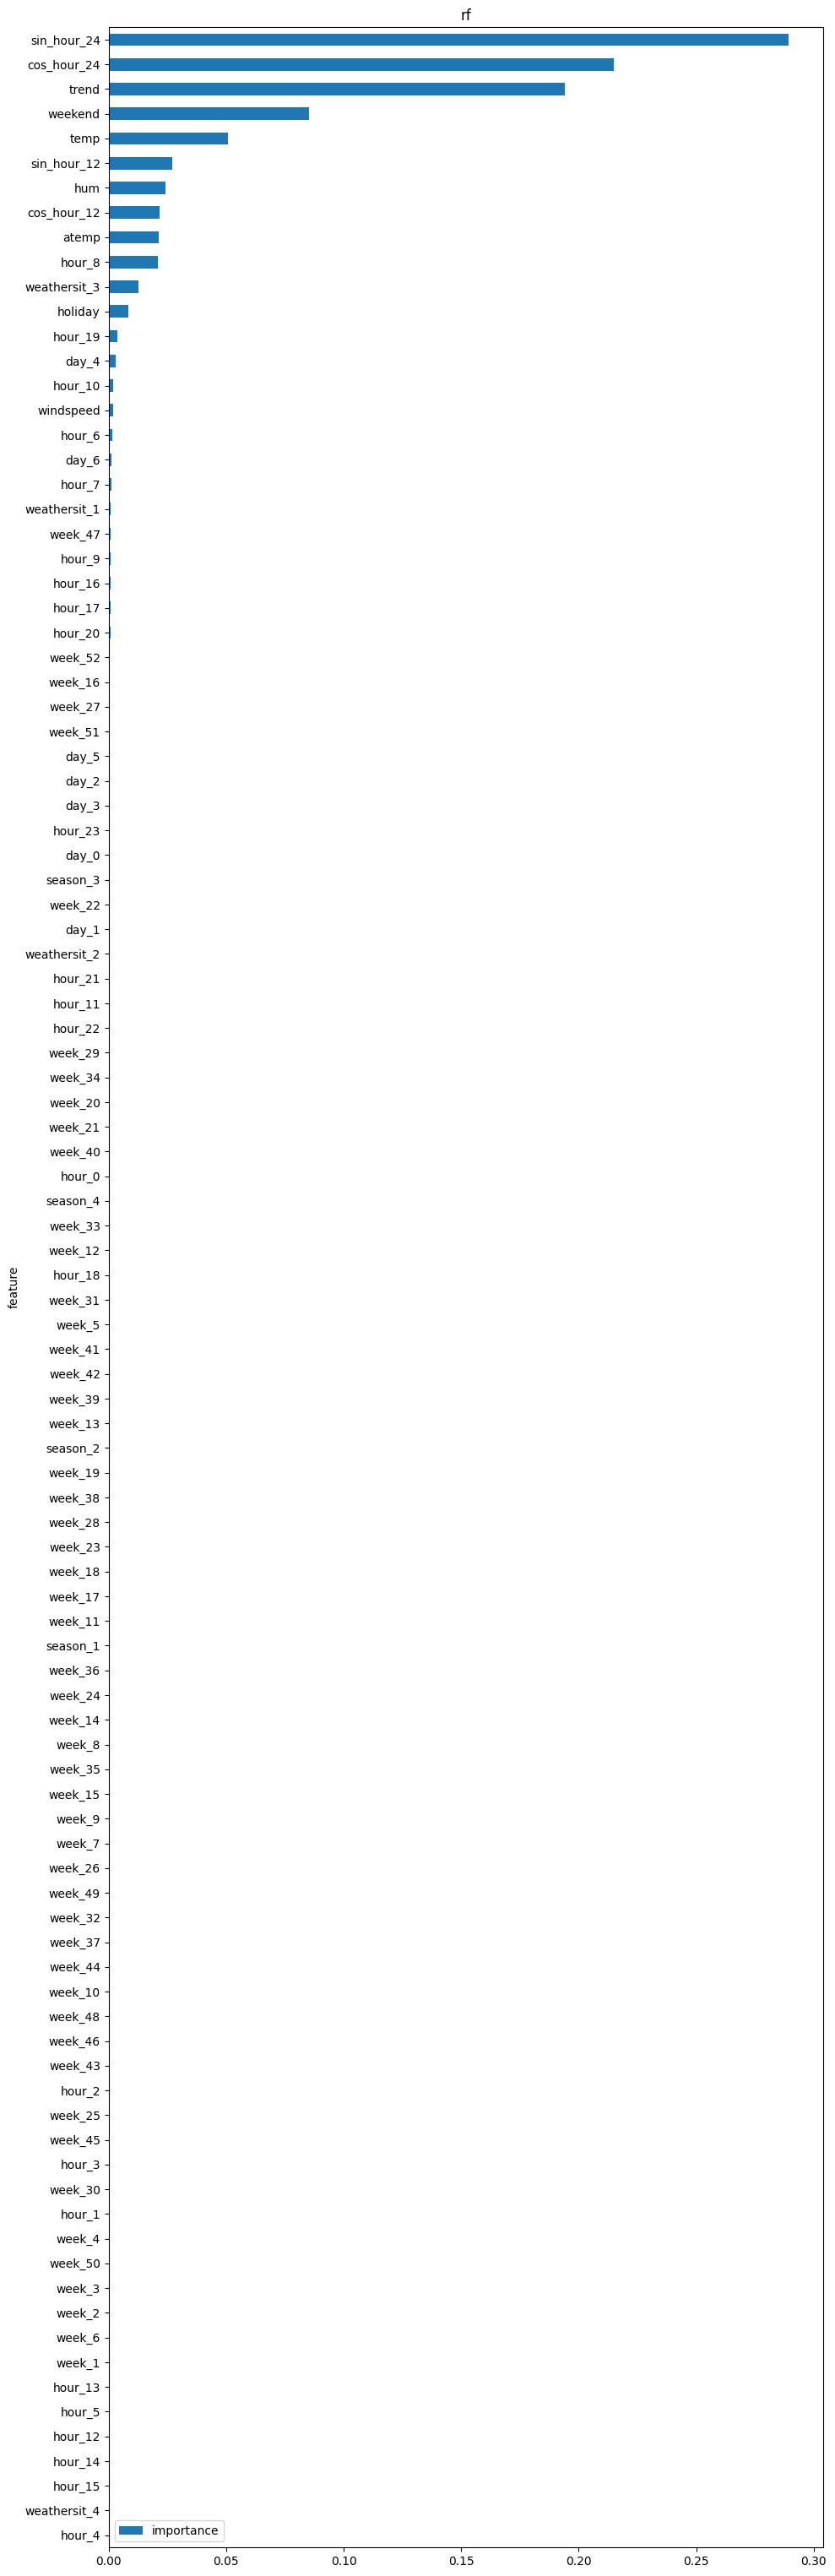

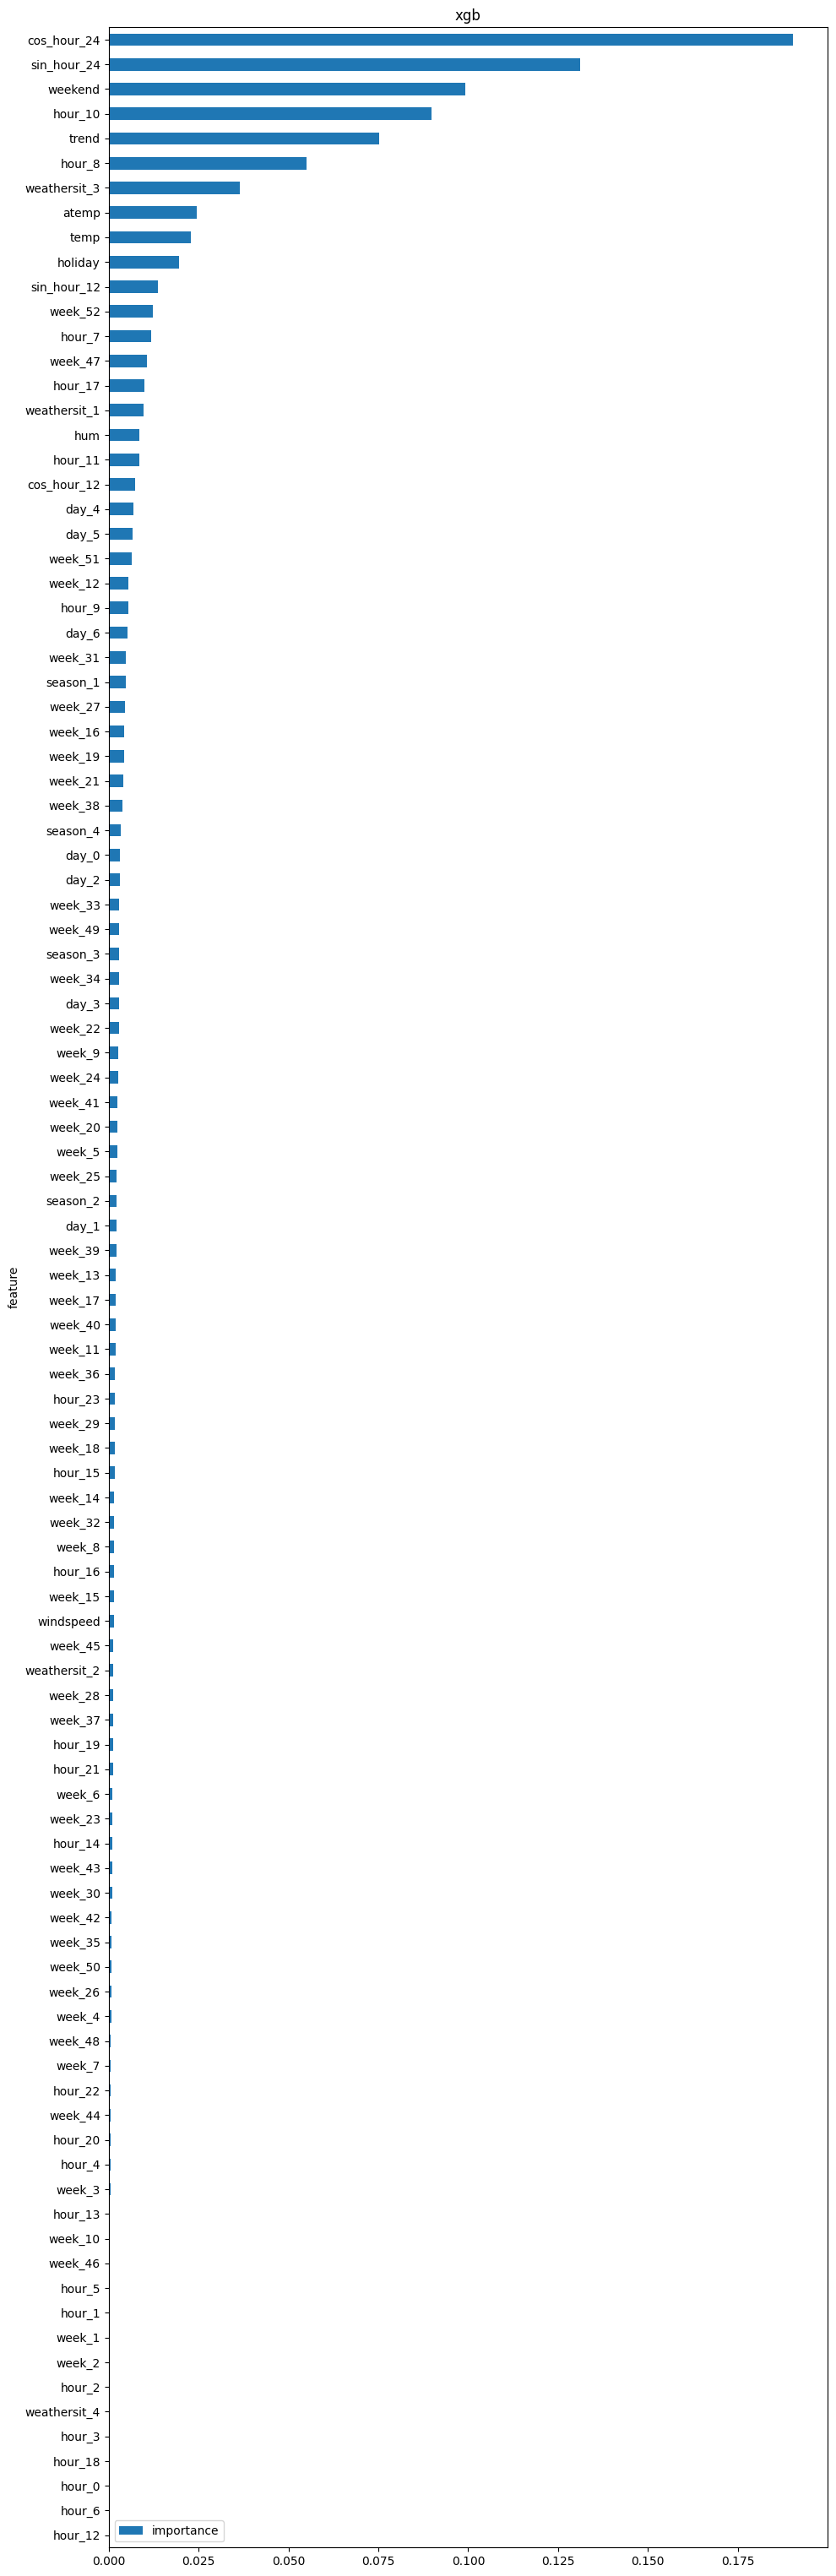

,holiday,temp,atemp,hum,windspeed,weekend,sin_hour_24,cos_hour_24,sin_hour_12,cos_hour_12,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,trend
date_hour,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0.24,0.2879,0.81,0.0,1,0.000000,1.000000,0.000000,1.000000e+00,...,False,False,False,False,False,False,False,False,False,1.0
2011-01-01 01:00:00,0,0.22,0.2727,0.80,0.0,1,0.258819,0.965926,0.500000,8.660254e-01,...,False,False,False,False,False,False,False,False,False,2.0
2011-01-01 02:00:00,0,0.22,0.2727,0.80,0.0,1,0.500000,0.866025,0.866025,5.000000e-01,...,False,False,False,False,False,False,False,False,False,3.0
2011-01-01 03:00:00,0,0.24,0.2879,0.75,0.0,1,0.707107,0.707107,1.000000,6.123234e-17,...,False,False,False,False,False,False,False,False,False,4.0
2011-01-01 04:00:00,0,0.24,0.2879,0.75,0.0,1,0.866025,0.500000,0.866025,-5.000000e-01,...,False,False,False,False,False,False,False,False,False,5.0


In [116]:
from sklearn.metrics import mean_squared_error
import numpy as np

class RegressionModels:
    def __init__(self, data, target, dummie_cols=False, shuffle=True, test_size=0.2, random_state=42):
        self.data = data
        if dummie_cols:
            self.data = pd.get_dummies(self.data, columns=dummie_cols)              
        self.X = self.data.drop(target, axis=1)
        self.y = self.data[[target]]        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                                                test_size=test_size, shuffle=shuffle, 
                                                                                random_state=random_state)
        
    def time_series_data(self, order, constant=False, drop=True):
        dp = DeterministicProcess(index=self.y_train.index, constant=constant, order=order, drop=drop)
        self.X_train2 = dp.in_sample()
        self.X_test2 = dp.out_of_sample(steps=len(self.y_test), forecast_index=self.y_test.index)
        
    def concat_data(self):
        # Voeg deze kolom toe aan X_train en X_test
        self.X_train = pd.concat([self.X_train, self.X_train2], axis=1)
        self.X_test = pd.concat([self.X_test, self.X_test2], axis=1)
    
    def predict(self, models=models_dict):
        # dict to store feature importances
        self.fi = {}
        self.models_dict = models
        for model in self.models_dict.items():            
            model[1].fit(self.X_train, self.y_train)
            self.y_train_pred = model[1].predict(self.X_train)
            self.y_test_pred = model[1].predict(self.X_test)
            train_rmse = np.sqrt(mean_squared_error(self.y_train, self.y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(self.y_test, self.y_test_pred))
            print(f'train RMSE {model[0]}: {train_rmse}')
            print(f'test RMSE {model[0]}: {test_rmse}')
            # only if attribute exists
            if hasattr(model[1], 'feature_importances_'):
                self.fi[model[0]] = model[1].feature_importances_

    def show_feature_importances(self):
        for fi in self.fi.items():
            feature_importance = pd.DataFrame(fi[1])
            cols = pd.DataFrame(self.X_train.columns)
            df_fi = pd.concat([cols, feature_importance], axis=1)
            df_fi.columns = ['feature', 'importance']
            df_fi.sort_values('importance', ascending=True, inplace=True)
            # Stel de hoogte van de figuur in afhankelijk van het aantal features
            num_features = len(df_fi)
            fig_height = max(6, num_features * 0.3)  # Dynamische hoogte, minimaal 6

            # Plot de grafiek
            df_fi.plot(
                kind='barh',
                x='feature',
                y='importance',
                title=fi[0],
                figsize=(10, fig_height)  # Breedte=10, hoogte variabel
            )
            plt.tight_layout()  # Zorg dat alles goed past
            plt.show()
        
data = RegressionModels(data=train, dummie_cols=['weathersit', 'week', 'day', 'season', 'hour'], target='cnt', shuffle=False, test_size=36*24)
print('Voor combineren features:')
data.predict()
data.time_series_data(order=1)
data.concat_data()
print('Na combineren features:')
data.predict()
data.show_feature_importances()

display(data.X_train.head())


## 4.2 Cross-validation voor time series

In [36]:
from sklearn.model_selection import TimeSeriesSplit
kf = TimeSeriesSplit(n_splits=10)
rf = RandomForestRegressor(n_jobs = -1, random_state=42)
param_grid = {"max_depth": [30, 35]} 
model_cv = GridSearchCV(rf, param_grid, cv = kf, n_jobs = -1)
model_cv.fit(data.X_train, data.y_train)
model_cv.best_params_, model_cv.best_score_

model_cv.cv_results_

NameError: name 'data' is not defined

### 4.2.1 Leg uit waarom dit anders is voor time series

Doordat je de toekomst wilt voorspellen, moet je elke keer als trainset data voor de testset pakken, dus bij crossvalidation wordt dat stukje trainset steeds groter ten opzichte van de testset.

# 5. Modelleren

Hieronder wordt aan de hand van de class een gridsearch uitgevoerd voor verschillende voorspellende modellen. De hyperparameters die eruit komen zullen worden gebruikt om de daadwerkelijke voorspellingen mee te doen. Dit zal in onderstaande paragrafen worden uitgevoerd en beschreven.

In [118]:
models_dict = {
               'lr': [ LinearRegression(), {} ],
               'dt': [ DecisionTreeRegressor(), {'max_depth': [3, 5, 7], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2, 3], 'max_features':['auto', 'sqrt', 'log2']} ],
               'rf': [ RandomForestRegressor(random_state=42, n_jobs=-1), {'n_estimators':[50, 100], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2, 3], 'max_features':['auto', 'sqrt', 'log2']} ],
               'knn': [ KNeighborsRegressor(), {'n_neighbors':[3, 5], 'weights': ['uniform', 'distance'] }  ],
               'xgb': [ XGBRegressor(random_state=42, n_jobs=-1), {'n_estimators':[50, 100], 'max_depth': [3,5], 'learning_rate': [0.01, 0.1, 0.3]} ]             
              }

In [119]:
from sklearn.metrics import mean_squared_error
import numpy as np

class RegressionModels:
    def __init__(self, data, target, dummie_cols=False, shuffle=True, test_size=0.2, random_state=42):
        self.data = data
        if dummie_cols:
            self.data = pd.get_dummies(self.data, columns=dummie_cols)              
        self.X = self.data.drop(target, axis=1)
        self.y = self.data[[target]]        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                                                test_size=test_size, shuffle=shuffle, 
                                                                                random_state=random_state)
        
    def time_series_data(self, order, constant=False, drop=True):
        dp = DeterministicProcess(index=self.y_train.index, constant=constant, order=order, drop=drop)
        self.X_train2 = dp.in_sample()
        self.X_test2 = dp.out_of_sample(steps=len(self.y_test), forecast_index=self.y_test.index)
        
    def concat_data(self):
        # Voeg deze kolom toe aan X_train en X_test
        self.X_train = pd.concat([self.X_train, self.X_train2], axis=1)
        self.X_test = pd.concat([self.X_test, self.X_test2], axis=1) 

    
    def tune_params(self, n_splits, models_dict=models_dict):
        self.models_dict = models_dict
        self.results = {}
        self.best_model = None
        self.best_params = None
        self.best_score = float('inf')
        kf = TimeSeriesSplit(n_splits=n_splits)
        for model in models_dict.items():
            model_cv = GridSearchCV(estimator=model[1][0], param_grid=model[1][1], cv=kf, n_jobs=-1, scoring='neg_root_mean_squared_error')
            model_cv.fit(self.X_train, self.y_train)
            self.results[model[0]] = [model_cv.best_params_, -model_cv.best_score_]
            print(model[0], self.results[model[0]])
            if -model_cv.best_score_ < self.best_score:
                self.best_score = -model_cv.best_score_
                self.best_model = model[0]
                self.best_params = model_cv.best_params_             
        
    def predict(self):
        # dict to store feature importances
        self.fi = {}
        for model_name, model_info in self.models_dict.items():
            model = model_info[0].set_params(**self.results[model_name][0])
            model.fit(self.X_train, self.y_train)
            self.y_train_pred = model.predict(self.X_train)
            self.y_test_pred = model.predict(self.X_test)
            train_rmse = np.sqrt(mean_squared_error(self.y_train, self.y_train_pred))
            test_rmse = np.sqrt(mean_squared_error(self.y_test, self.y_test_pred))
            print(f'train RMSE {model_name}', train_rmse)
            print(f'test RMSE {model_name}', test_rmse)
            # only if attribute exists
            if hasattr(model, 'feature_importances_'):
                self.fi[model_name] = model.feature_importances_
                
    def show_feature_importances(self):
        for fi in self.fi.items():
            feature_importance = pd.DataFrame(fi[1])
            cols = pd.DataFrame(self.X_train.columns)
            df_fi = pd.concat([cols, feature_importance], axis=1)
            df_fi.columns = ['feature', 'importance']
            df_fi.sort_values('importance', ascending=True, inplace=True)
            # Stel de hoogte van de figuur in afhankelijk van het aantal features
            num_features = len(df_fi)
            fig_height = max(6, num_features * 0.3)  # Dynamische hoogte, minimaal 6

            # Plot de grafiek
            df_fi.plot(
                kind='barh',
                x='feature',
                y='importance',
                title=fi[0],
                figsize=(10, fig_height)  # Breedte=10, hoogte variabel
            )
            plt.tight_layout()  # Zorg dat alles goed past
            plt.show()
               
    
data = RegressionModels(data=train, dummie_cols=['weathersit', 'week', 'day', 'season', 'hour'], target='cnt', shuffle=False, test_size=19*24 )
data.time_series_data(order=1)
data.concat_data() 
data.tune_params(n_splits = int(round(len(train)/len(test), 0)))
data.results

lr [{}, 8718116.790907817]
dt [{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6}, 121.14066942819098]
rf [{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}, 105.57617688416532]
knn [{'n_neighbors': 5, 'weights': 'distance'}, 211.5382865615378]
xgb [{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, 55.86615058446085]


{'lr': [{}, 8718116.790907817],
 'dt': [{'max_depth': 7,
   'max_features': 'sqrt',
   'min_samples_leaf': 2,
   'min_samples_split': 6},
  121.14066942819098],
 'rf': [{'max_depth': 7,
   'max_features': 'sqrt',
   'min_samples_leaf': 1,
   'min_samples_split': 6,
   'n_estimators': 100},
  105.57617688416532],
 'knn': [{'n_neighbors': 5, 'weights': 'distance'}, 211.5382865615378],
 'xgb': [{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
  55.86615058446085]}

# **Hou bij welke hyperparameters je gebruikt voor elke kaggle submission voor 6.3**

## 5.1 (Lineaire regressie) Model 1 waar je time series combineert met reguliere feautures (Lineaire regressie)

### 5.1.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.1.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.1.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.2 (Decision Tree) Model 2 waar je time series combineert met reguliere feautures (Decision Tree)

### 5.2.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.2.2 Geef toelichting in de werking van het model en de gekozen parameters

**De werking van een decision tree**

Een decision tree begint met de gehele dataset als input voor de voorspelling. Bij dit model wordt een dataset herhaaldelijk gesplitst in kleinere subsets op basis van 'beslissingsregels' tot het model voldoende specifieke subsets heeft om een duidelijke voorspelling te maken.

De regressie versie van een decision tree wordt per boom gesplitst op een andere manier dan dat het gebeurt bij een classifier. In plaats van dat er wordt gekeken naar de information gain & gini impurity, wordt er hierbij gebruikt gemaakt van de MSE (Mean Squared Error). Deze metric berekent hoe ver de werkelijke waarden afwijken van de voorspelde waarde (het gemiddelde in een 'leaf' van de tree). De bomen proberen elke splitsing zo te maken dat de voorspeelde waarde zo nauwkeurig mogelijk is. Het model kiest uiteindelijk elke keer de splitsing die de grootste reductie in de variatie (fout) oplevert. 

Deze manier van splitsen wordt herhaald voor elke keer opnieuw gevormde subset met een nieuwe feature (kolom) en splitsingregel. Dit proces gaat door tot er aan een bepaalde stopcriteria wordt voldaan (variatie binnen de groep is niet verder te verminderen of het wordt 'handmatig' gestopt d.m.v. pruning, denk hierbij aan max depth, min samples split etc.)

Dit is de MSE functie die wordt gebruikt bij het maken van de splitsingen:

$$
MSE = \frac{1}{n} \sum_{i=1}^n (Y_i - \hat{Y})^2
$$

Werkelijke waarde

$$ Y_i $$

Voorspelde waarde (gemiddelde van de groep)
$$ \hat{Y} $$

Aantal gegevenspunten in de groep (samples)
$$ {n} $$

### 5.2.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.3 (Random Forest) Model 3 waar je time series combineert met reguliere feautures

### 5.3.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.3.2 Geef toelichting in de werking van het model en de gekozen parameters

**Random Forest**

Random forest is gebaseerd op bagging. Bij bagging worden meerdere versies van hetzelfde model getrain op verschillende subets van de dataset, die wordt verkregen door boostrapping. Dit houdt in dat er nieuwe datasets worden gecreëerd door samples uit de oorspronkelijke dataset te trekken met "terugleggen" (dezelfde datapunten kunnen meerdere keren worden geselecteerd), genaamd bootstrap samples. 

Daarnaast worden er ook willekeurige features (kolommen) gekozen. Bij elke splitsing van een tree, wordt slechts een willekeurige subset van de beschikbare features overwogen, in plaats van alle features. Het voordeel hiervan is dat de trees minder met elkaar gecorreleerd zijn en onafhankelijkere fouten maken.

Elke tree van het model voorspelt een continu (numeriek) resultaat, en het uiteindelijke resultaat van de random forest wordt berekend door het gemiddelde van de voorspellingen van alle bomen te nemen. 

Voordelen:  
-Doordat er meerdere modellen naast elkaar worden getrained, kan het overfitting voorkomen.   
-Doordat de trees onafhankelijk van elkaar worden getrained, kunnen ze parallel worden verwerkt. Hierdoor is de trainingstijd dus relatief snel in vergelijking met Gradient Descent Boosting.   

Nadelen:  
-Ze zijn lastiger te interpreteren dan een losse decision tree.   
-Er zijn veel hyper parameters om te tunen.   

**Wiskunde**

Aangezien een random forest het gemiddelde van alle voorspelling van de individuele bomen pakt, moet deze worden berekend. Dit wordt gedaan aan de hand van de onderstaande formule, waarbij K het aantal bomen in de forest is:

$$
\hat{y}(x) = \frac{1}{K} \sum_{k=1}^{K} f_k(x)
$$

Net zoals bij decision trees wordt er gebruik gemaakt van de MSE metric om te bepalen wat de beste splitsingen zijn:

$$
MSE = \frac{1}{n} \sum_{i=1}^n (Y_i - \hat{Y})^2
$$


### 5.3.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.4 (KNN) Model 4 waar je time series combineert met reguliere feautures

### 5.4.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.4.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.4.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.5 (XGBoost) Model 5 waar je time series combineert met reguliere feautures

### 5.5.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.5.2 Geef toelichting in de werking van het model en de gekozen parameters

Stap-voor-stap proces: Hoe komt XGBoost tot een voorspelling?

**Het basisidee: Gradient Boosting**

XGBoost volgt het principe van Gradient Boosting, waarbij modellen (in dit geval beslisbomen) iteratief worden toegevoegd om fouten te corrigeren die de vorige bomen hebben gemaakt.

•	**Start**: Het proces begint met een eenvoudige voorspelling, zoals het gemiddelde van de doelvariabele y (voor regressie). Deze voorspelling heet $$F_0(x)$$

•	**Iteratieve verbetering**: In elke volgende stap t, wordt een nieuwe beslisboom getraind om de residuen $$(r_i = y_i - F_{t-1}(x_i))$$ te voorspellen, oftewel de fouten van het vorige model.


•	**Update**: De voorspelling wordt aangepast met een fractie van de nieuwe boom $$\eta \times \text{nieuw model}$$ waarbij η de learning rate is.

$$F_t(x) = F_{t-1}(x) + \eta \cdot h_t(x)$$

Hier is $$h_t(x)$$ de beslisboom die in stap t wordt toegevoegd.
________________________________________
**Hoe beslisbomen bijdragen aan de voorspelling**

Een beslisboom in XGBoost splitst de dataset herhaaldelijk op basis van kenmerken die de grootste foutreductie opleveren. Elke knoop in de boom verdeelt de data in kleinere groepen, zodat de eindwaarden (ook wel "leaf values" genoemd) de fouten minimaliseren.

•	Bij regressie wordt de voorspelling aangepast met de som van de waardes in de bladeren waar de data-eenheden terechtkomen.

•	Voorbeeld: 

Stel dat je het energieverbruik van een huis wilt voorspellen. Een boom splitst op kenmerken zoals temperatuur, dag van de week, en tijdstip. Als een waarneming in een blad terechtkomt met een waarde van +2,5, wordt dit toegevoegd aan de vorige voorspelling.

________________________________________
**Optimalisaties en hun rol in het proces**

**Regularisatie**: Hoe blijft het model simpel en algemeen?

XGBoost gebruikt L1- en L2-regularisatie om de waarden van de bladeren en de splitsingen in te perken.

•	L1-regularisatie: Zorgt ervoor dat sommige bladeren een waarde van exact 0 krijgen, wat betekent dat die splitsingen geen invloed hebben op de uiteindelijke voorspelling.

•	L2-regularisatie: Voorkomt dat bladwaarden extreem groot worden, wat helpt om de stabiliteit van de voorspellingen te waarborgen.

Praktisch voorbeeld:

Bij een dataset over huizenprijzen kan een splitsing zoals "heeft het huis een zwembad?" alleen blijven bestaan als deze voldoende bijdraagt aan de voorspellingen. Anders wordt de splitsing genegeerd door de regularisatie.
________________________________________
**Parallel trainen: Hoe worden splitsingen sneller gemaakt?**

Binnen één beslisboom wordt voor elk kenmerk berekend hoe effectief een splitsing is bij het reduceren van fouten. XGBoost verdeelt deze berekeningen over meerdere CPU-cores, wat de training aanzienlijk versnelt.

•	Voorbeeld:

Bij een dataset met 100 kenmerken wordt berekend welke splitsingen de foutreductie maximaliseren. Dit gebeurt parallel voor alle kenmerken, waardoor XGBoost sneller beslisbomen kan bouwen.
________________________________________
**Tree pruning: Hoe blijven bomen efficiënt?**

Bij het bouwen van een boom evalueert XGBoost of het toevoegen van een splitsing de prestaties voldoende verbetert. Splitsingen die weinig bijdragen, worden achteraf verwijderd (post-pruning).

•	Voorbeeld:

Bij een verkeersdataset kan een splitsing op "weertype" slechts een minieme foutreductie geven. In dat geval wordt deze splitsing verwijderd om te voorkomen dat het model onnodig complex wordt.
________________________________________
**Learning rate (eta): Hoe worden fouten voorzichtig gecorrigeerd?**

De learning rate bepaalt hoeveel elke boom bijdraagt aan de uiteindelijke voorspelling. Dit voorkomt dat het model overreageert op fouten in de trainingsdata.

•	Praktisch voorbeeld:

Bij de voorspelling van verkoopcijfers kan een hoge learning rate leiden tot te sterke aanpassingen gebaseerd op tijdelijke promoties. Een lage learning rate zorgt ervoor dat het model trends en patronen op lange termijn beter oppikt.
________________________________________
**Schaalbaarheid: Hoe gaat XGBoost om met grote datasets?**

Bij datasets die niet in het geheugen passen, verwerkt XGBoost de data in kleine batches (out-of-core computing). Dit maakt het mogelijk om efficiënt met grote tijdreeksen of datasets met miljoenen rijen te werken.

•	Praktisch voorbeeld:

Voor een dataset met energieverbruik van duizenden huishoudens verwerkt XGBoost telkens een deel van de data, waardoor het model op een standaardlaptop kan worden getraind.
________________________________________
**Hoe komt XGBoost uiteindelijk tot een voorspelling?**

-	Initiële voorspelling:

XGBoost begint met een eenvoudige voorspelling, zoals het gemiddelde van y.
$$F_0(x) = \text{Gemiddelde}(y) $$

-	Fouten berekenen:

De fouten $$ri= y_i - F_{t-1}(x_i)$$ worden berekend op basis van de vorige voorspelling.

-	Nieuwe boom trainen:

Een nieuwe beslisboom wordt getraind op de residuen $$(r_i)$$ waarbij splitsingen worden gemaakt die de foutreductie maximaliseren.

-	Voorspelling updaten:

De uiteindelijke voorspelling wordt aangepast met de bijdrage van de nieuwe boom $$(h_t(x))$$ geschaald door de learning rate η.

$$F_t(x) = F_{t-1}(x) + \eta \cdot h_t(x)$$

-	Iteraties herhalen:

Dit proces wordt herhaald totdat het gewenste aantal bomen is bereikt of de fout niet verder afneemt.
________________________________________
Samenvatting in een concreet voorbeeld

Stel, je wilt de maandelijkse elektriciteitsrekening van een huishouden voorspellen.

1.	Initiële voorspelling: Het model voorspelt eerst het gemiddelde elektriciteitsgebruik, bijvoorbeeld 300 kWh.

2.	Fout berekenen: Het model berekent de afwijking voor elk huishouden (bijv. eentje gebruikt 250 kWh, dus de fout is -50 kWh).

3.	Nieuwe boom: Een boom wordt getraind om de fouten (-50 kWh) te minimaliseren, bijvoorbeeld door splitsingen te maken op "aantal bewoners" en "airconditioninggebruik".

4.	Voorspelling aanpassen: De nieuwe voorspelling wordt 300 + (0,1 * foutcorrectie), waarbij 0,1 de learning rate is.

5.	Iteraties: Het proces wordt herhaald, waarbij iedere boom beter wordt in het corrigeren van de resterende fouten.

Zo ontstaat een krachtige regressiemodel dat zowel korte- als langetermijntrends leert, zonder over te fitten op irrelevante details.

ChatGPT - XGBoost regressie uitleg. (n.d.). ChatGPT. https://chatgpt.com/share/6744dd90-bf5c-8002-8884-6606bfdb29c5

XGBoost Documentation — xgboost 2.1.1 documentation. (n.d.). https://xgboost.readthedocs.io/en/stable/

### 5.5.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.6 (SARIMA) Model 1 van specifieke tijdseriemodellen (SARIMAX)

In [121]:
models_dict = {'sx': SARIMAX(endog=train['cnt']),
               }

In [122]:
class TimeSeriesModels:
    def __init__(self, data, target, dummie_cols=False, shuffle=True, test_size=0.2, random_state=42):
        self.data = data
        if dummie_cols:
            self.data = pd.get_dummies(self.data, columns=dummie_cols)              
        self.X = self.data.drop(target, axis=1)
        self.y = self.data[[target]]        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                                                test_size=test_size, shuffle=shuffle, 
                                                                                random_state=random_state)
        
    def time_series_data(self, order, constant=False, drop=True):
        dp = DeterministicProcess(index=self.y_train.index, constant=constant, order=order, drop=drop)
        self.X_train2 = dp.in_sample()
        self.X_test2 = dp.out_of_sample(steps=len(self.y_test), forecast_index=self.y_test.index)
        
    def concat_data(self):
        # Voeg deze kolom toe aan X_train en X_test
        self.X_train = pd.concat([self.X_train, self.X_train2], axis=1)
        self.X_test = pd.concat([self.X_test, self.X_test2], axis=1)
    
    def predict(self, models=models_dict):
        self.models_dict = models
        for name, model in self.models_dict.items():
            if isinstance(model, SARIMAX):
                fitted_model = model.fit(disp=False)
                self.y_train_pred = fitted_model.predict(start=self.y_train.index[0], end=self.y_train.index[-1])
                self.y_test_pred = fitted_model.predict(start=self.y_test.index[0], end=self.y_test.index[-1])
            else:
                model.fit(self.X_train, self.y_train)
                self.y_train_pred = model.predict(self.X_train)
                self.y_test_pred = model.predict(self.X_test)
            
            print(f'{name} train r2:', r2_score(self.y_train, self.y_train_pred))
            print(f'{name} test r2:', r2_score(self.y_test, self.y_test_pred))
    
#    def show_feature_importances(self):
#        for fi in self.fi.items():
#            feature_importance = pd.DataFrame(fi[1])
#            cols = pd.DataFrame(self.X_train.columns)
#            df_fi = pd.concat([cols, feature_importance], axis=1)
#            df_fi.columns = ['feature', 'importance']
#            df_fi.sort_values('importance', ascending=True, inplace=True)
#            # Stel de hoogte van de figuur in afhankelijk van het aantal features
#            num_features = len(df_fi)
#            fig_height = max(6, num_features * 0.3)  # Dynamische hoogte, minimaal 6
#
#            # Plot de grafiek
#            df_fi.plot(
#                kind='barh',
#                x='feature',
#                y='importance',
#                title=fi[0],
#                figsize=(10, fig_height)  # Breedte=10, hoogte variabel
#            )
#            plt.tight_layout()  # Zorg dat alles goed past
#            plt.show()
        
data = TimeSeriesModels(data=train, dummie_cols=['weathersit', 'week', 'day', 'season', 'hour'], target='cnt', shuffle=False, test_size=36*24 )
print('Voor combineren features:')
data.predict()
data.time_series_data(order=1)
data.concat_data()
print('Na combineren features:')
data.predict()
#data.show_feature_importances()

display(data.X_train.head())


Voor combineren features:
sx train r2: 0.7025648077647062
sx test r2: 0.6553916203485779
Na combineren features:
sx train r2: 0.7025648077647062
sx test r2: 0.6553916203485779


,holiday,temp,atemp,hum,windspeed,weekend,sin_hour_24,cos_hour_24,sin_hour_12,cos_hour_12,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,trend
date_hour,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0.24,0.2879,0.81,0.0,1,0.000000,1.000000,0.000000,1.000000e+00,...,False,False,False,False,False,False,False,False,False,1.0
2011-01-01 01:00:00,0,0.22,0.2727,0.80,0.0,1,0.258819,0.965926,0.500000,8.660254e-01,...,False,False,False,False,False,False,False,False,False,2.0
2011-01-01 02:00:00,0,0.22,0.2727,0.80,0.0,1,0.500000,0.866025,0.866025,5.000000e-01,...,False,False,False,False,False,False,False,False,False,3.0
2011-01-01 03:00:00,0,0.24,0.2879,0.75,0.0,1,0.707107,0.707107,1.000000,6.123234e-17,...,False,False,False,False,False,False,False,False,False,4.0
2011-01-01 04:00:00,0,0.24,0.2879,0.75,0.0,1,0.866025,0.500000,0.866025,-5.000000e-01,...,False,False,False,False,False,False,False,False,False,5.0


### 5.6.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.6.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.6.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.7 (ARIMA) Model 2 van specifieke tijdseriemodellen

### 5.7.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.7.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.7.3 Pas het model toe op de testset en upload het resultaat op Kaggle

## 5.8 Model 1 van hybdride modellen

### 5.8.1 Vind de beste hyperparameters, gebruik hier eventueel gridsearch en pipelines

### 5.8.2 Geef toelichting in de werking van het model en de gekozen parameters

### 5.8.3 Pas het model toe op de testset en upload het resultaat op Kaggle

# 6. Bevindingen

## 6.1 Geef een beknopt overzicht van de resultaten

## 6.2 Welke model presteert het beste? Welke parameters gebruikte deze?

## 6.3 Toon je scores op Kaggle en laat zien wat de resultaten waren van verbeteringen op je score op Kaggle

# 7. Conclusie en aanbevelingen

## 7.1 welke features hadden uiteindelijk het meeste invloed op de voorspelling?

## 7.2 Sluit dit aan op de EDA?

## 7.3 Welk advies kun je op basis hiervan geven aan de verhuurder?

## 7.4 Welk model zou je adviseren aan de verhuurder? Waarom? Is dit per definitie het model met de beste voorspellingen of zijn  er ook andere overwegingen? Zo ja, welke?